<a href="https://colab.research.google.com/github/alen-a-tech/maths-site-main/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22BiO_workshop_2025%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The three types of models for the neural encoding

# The "What" perspective

(based on [Tutorial](https://compneuro.neuromatch.io/tutorials/W1D1_ModelTypes/student/W1D1_Intro.html) by the Neuromatch Academy)

---
# Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Plotting functions

def plot_isis(single_neuron_isis):
  plt.hist(single_neuron_isis, bins=50, histtype="stepfilled")
  plt.axvline(single_neuron_isis.mean(), color="orange", label="Mean ISI")
  plt.xlabel("ISI duration (s)")
  plt.ylabel("Number of spikes")
  plt.legend()

In [ ]:
#@title Data retrieval
#@markdown This cell downloads the example dataset that we will use in this tutorial.
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Failed to download data')
else:
  spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

---

# Exploring the Steinmetz dataset

In this tutorial we will explore the structure of a neuroscience dataset.

We consider a subset of data from a study of [Steinmetz _et al._ (2019)](https://www.nature.com/articles/s41586-019-1787-x). In this study, Neuropixels probes were implanted in the brains of mice. Electrical potentials were measured by hundreds of electrodes along the length of each probe. Each electrode's measurements captured local variations in the electric field due to nearby spiking neurons. A spike sorting algorithm was used to infer spike times and cluster spikes according to common origin: a single cluster of sorted spikes is causally attributed to a single neuron.

In particular, a single recording session of spike times and neuron assignments was loaded and assigned to `spike_times` in the preceding setup.

Typically a dataset comes with some information about its structure. However, this information may be incomplete. You might also apply some transformations or "pre-processing" to create a working representation of the data of interest, which might go partly undocumented depending on the circumstances. In any case it is important to be able to use the available tools to investigate unfamiliar aspects of a data structure.

Let's see what our data looks like...

What is the Python type of our variable?

In [ ]:
type(spike_times)

numpy.ndarray

You should see `numpy.ndarray`, which means that it's a normal NumPy array.

If you see an error message, it probably means that you did not execute the set-up cells at the top of the notebook. So go ahead and make sure to do that.

Once everything is running properly, we can ask the next question about the dataset: what's its shape?

In [ ]:
spike_times.shape

(734,)

There are 734 entries in one dimension, and no other dimensions. What is the Python type of the first entry, and what is *its* shape?

In [ ]:
idx = 0
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)

<class 'numpy.ndarray'>
(826,)


It's also a NumPy array with a 1D shape! Why didn't this show up as a second dimension in the shape of `spike_times`? That is, why not `spike_times.shape == (734, 826)`?

To investigate, let's check another entry.

In [ ]:
idx = 321
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)

<class 'numpy.ndarray'>
(9723,)


It's also a 1D NumPy array, but it has a different shape. Checking the NumPy types of the values in these arrays, and their first few elements, we see they are composed of floating point numbers (not another level of `np.ndarray`):

In [ ]:
i_neurons = [0, 321]
i_print = slice(0, 5)

for i in i_neurons:
  print(
    "Neuron {}:".format(i),
    spike_times[i].dtype,
    spike_times[i][i_print],
    "\n",
    sep="\n"
  )

Neuron 0:
float32
[ 0.8149   14.822467 24.9646   25.1436   38.8709  ]


Neuron 321:
float32
[1.0698667 1.1536334 1.2403667 1.7072    1.799    ]




Note that this time we've checked the NumPy `dtype` rather than the Python variable type. These two arrays contain floating point numbers ("floats") with 32 bits of precision.

The basic picture is coming together:
- `spike_times` is 1D, its entries are NumPy arrays, and its length is the number of neurons (734): by indexing it, we select a subset of neurons.
- An array in `spike_times` is also 1D and corresponds to a single neuron; its entries are floating point numbers, and its length is the number of spikes attributed to that neuron. By indexing it, we select a subset of spike times for that neuron.

Visually, you can think of the data structure as looking something like this:

```
| . . . . . |
| . . . . . . . . |
| . . . |
| . . . . . . . |
```

Before moving on, we'll calculate and store the number of neurons in the dataset and the number of spikes per neuron:

In [ ]:
n_neurons = len(spike_times)
total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in spike_times]

print(f"Number of neurons: {n_neurons}")
print(f"Number of spikes for first five neurons: {total_spikes_per_neuron[:5]}")

Number of neurons: 734
Number of spikes for first five neurons: [826, 2818, 3953, 646, 1115]


## Counting and plotting total spike counts

As we've seen, the number of spikes over the entire recording is variable between neurons. More generally, some neurons tend to spike more than others in a given period. Let's explore what the distribution of spiking looks like across all the neurons in the dataset.

Are most neurons "loud" or "quiet", compared to the average? To see, we'll define bins of constant width in terms of total spikes and count the neurons that fall in each bin. This is known as a "histogram".

You can plot a histogram with the matplotlib function `plt.hist`. If you just need to compute it, you can use the numpy function `np.histogram` instead.

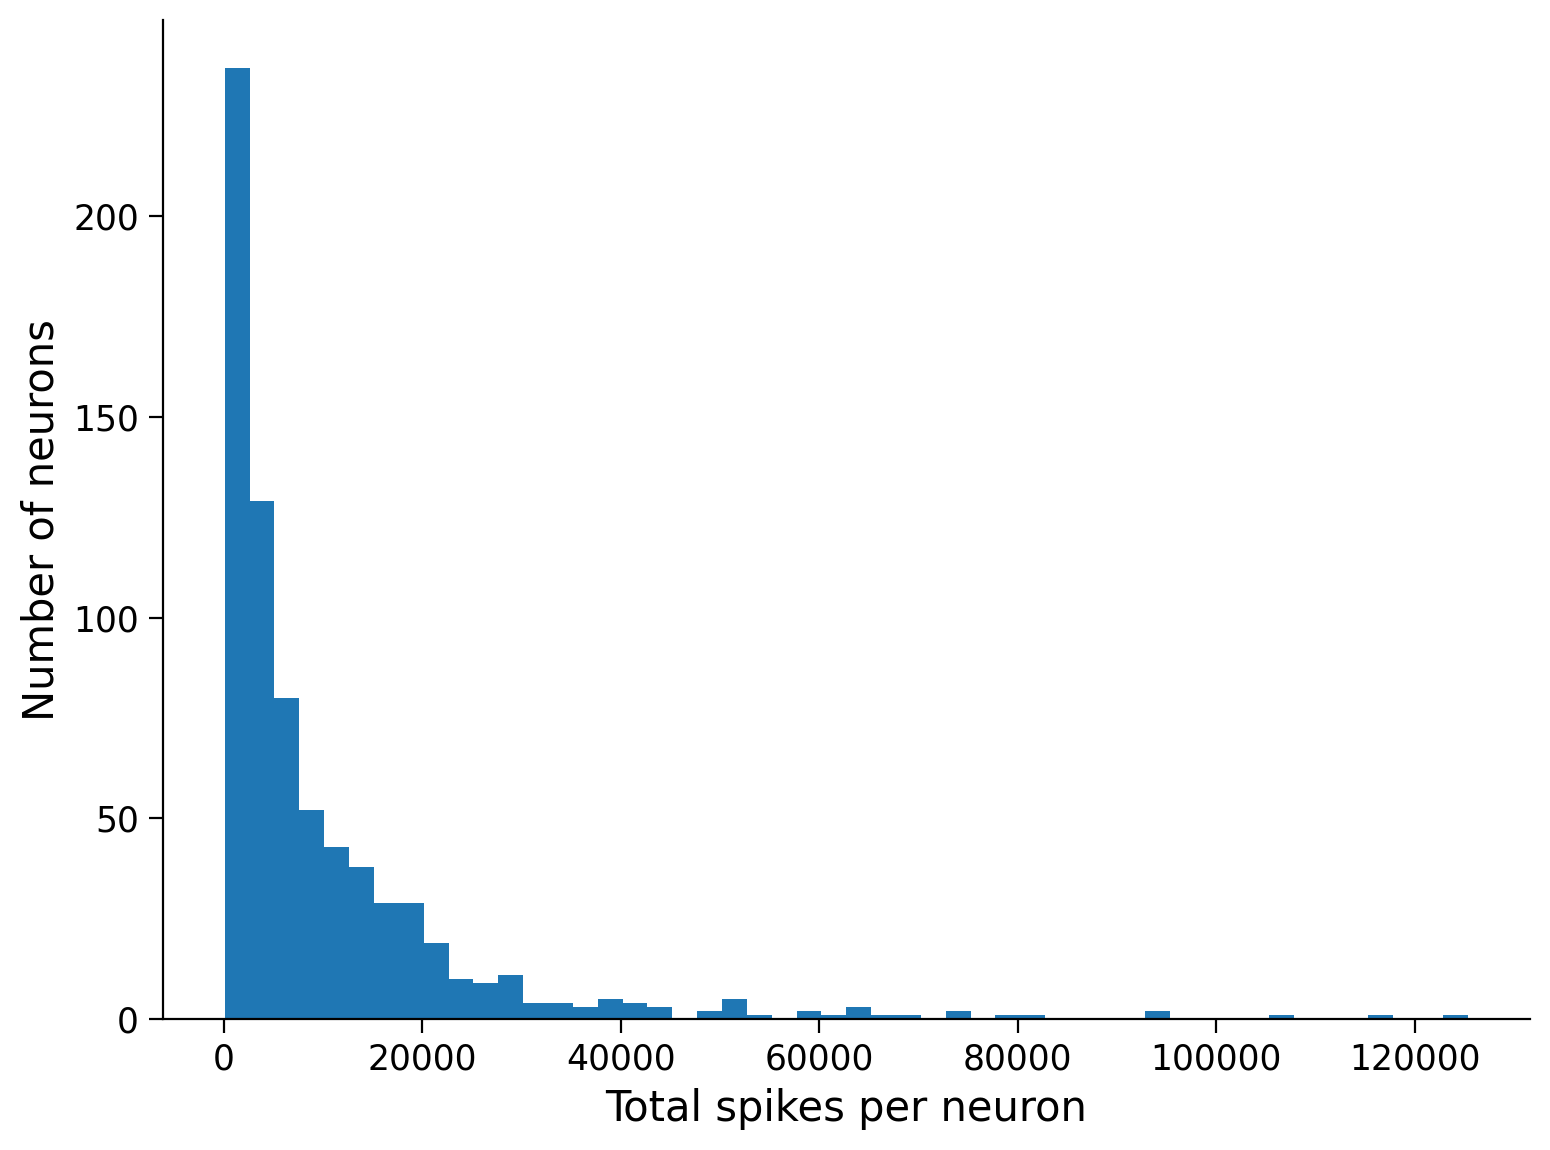

In [ ]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons");

Let's see what percentage of neurons have a below-average spike count:

In [ ]:
mean_spike_count = np.mean(total_spikes_per_neuron)
frac_below_mean = (total_spikes_per_neuron < mean_spike_count).mean()
print(f"{frac_below_mean:2.1%} of neurons are below the mean")

68.0% of neurons are below the mean


We can also see this by adding the average spike count to the histogram plot:

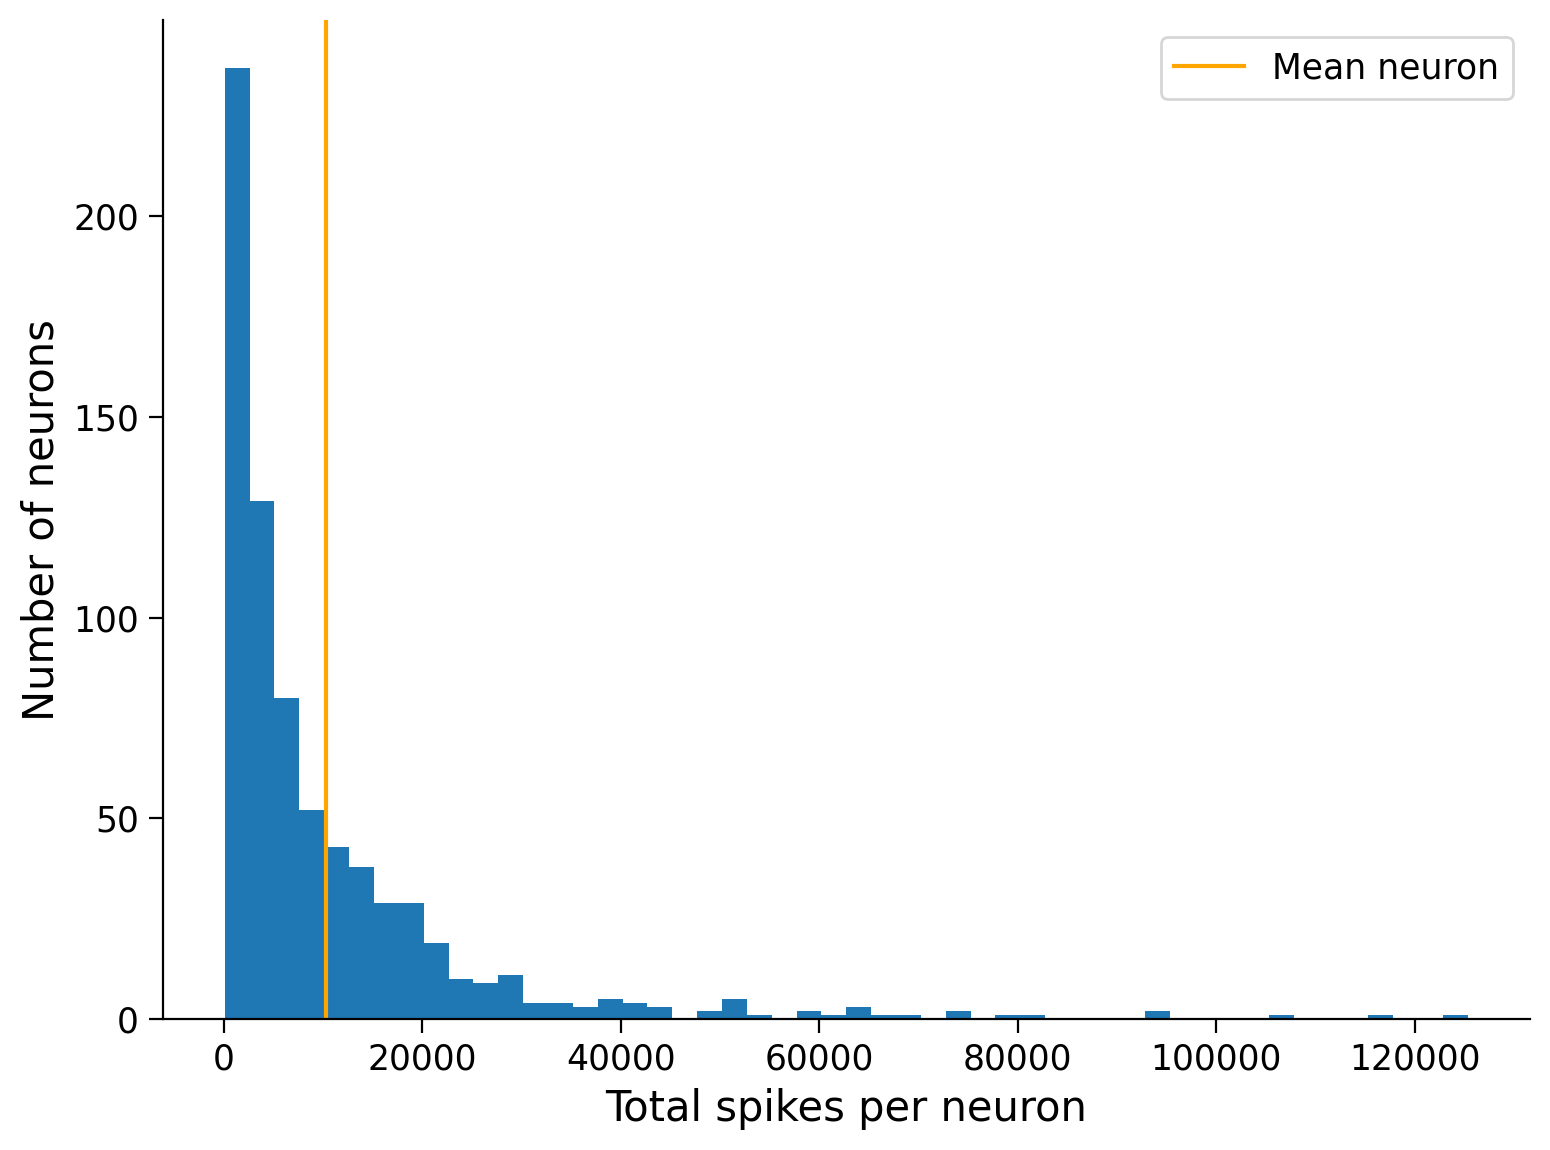

In [ ]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.legend();

This shows that the majority of neurons are relatively "quiet" compared to the mean, while a small number of neurons are exceptionally "loud": they must have spiked more often to reach a large count.

### Comparing mean and median neurons

If the mean neuron is more active than 68% of the population, what does that imply about the relationship between the mean neuron and the median neuron?


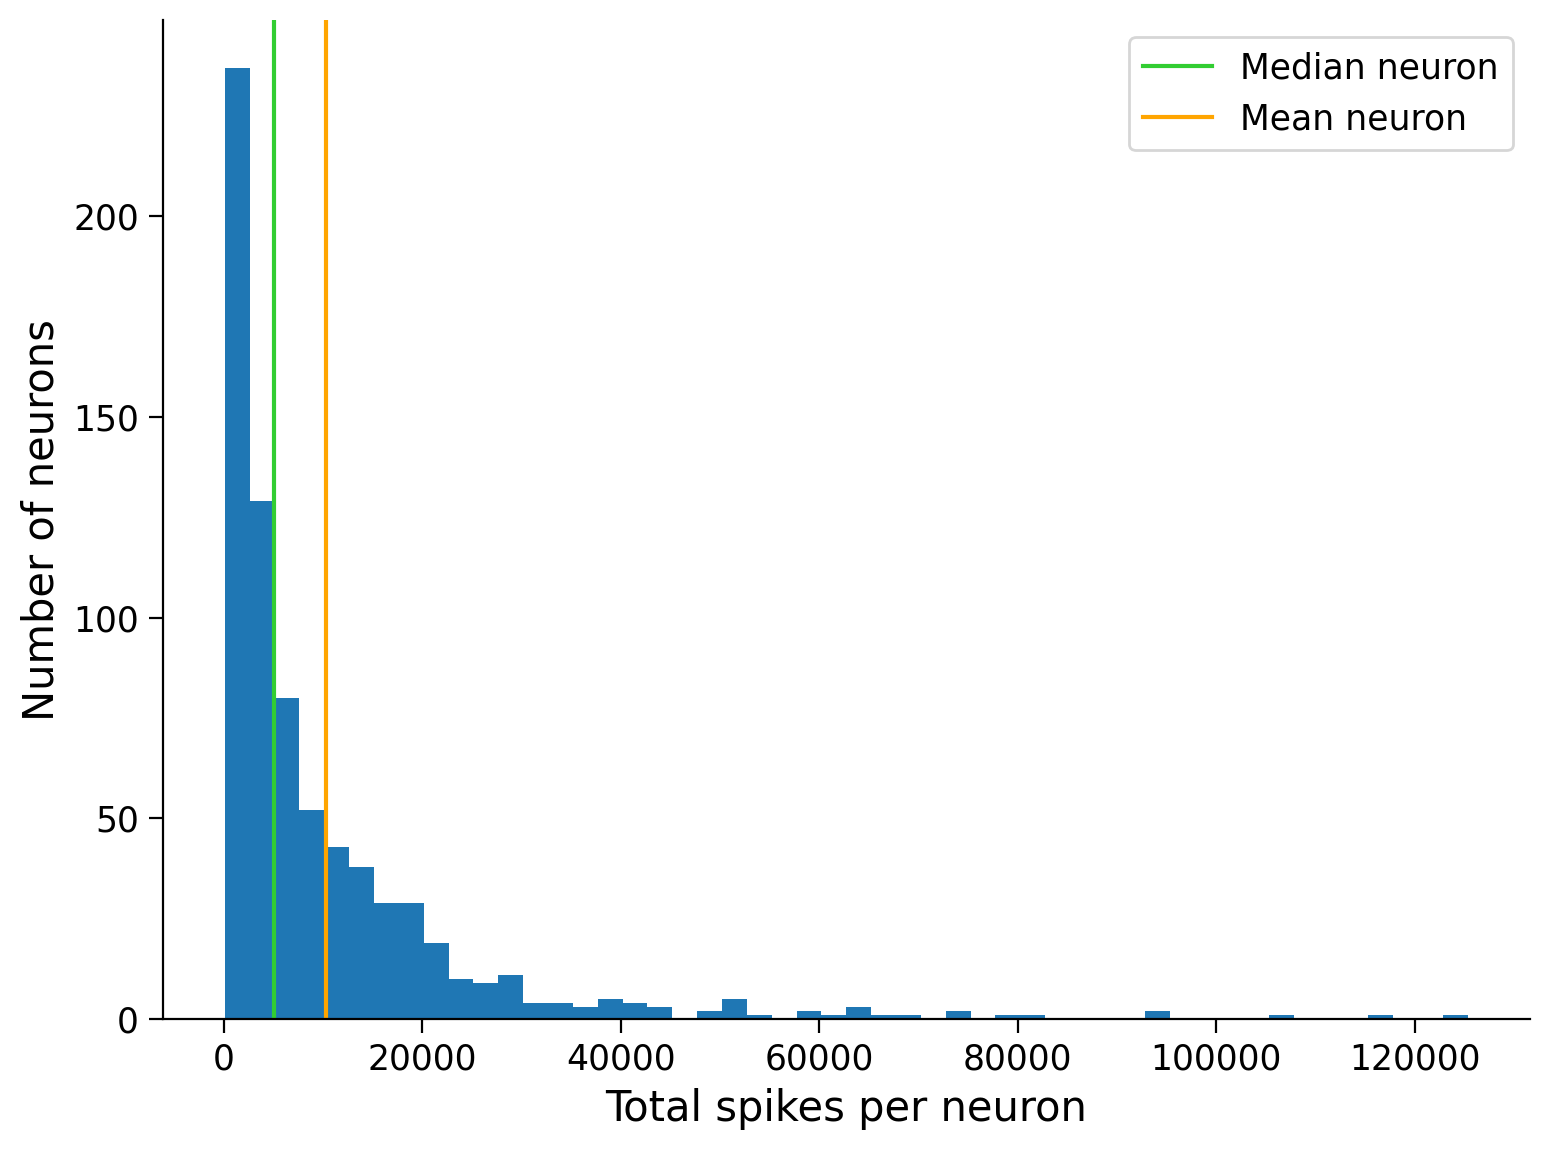

In [ ]:
# Compute median spike count
median_spike_count = np.median(total_spikes_per_neuron)

# Visualize median, mean, and histogram
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.axvline(median_spike_count, color="limegreen", label="Median neuron")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.legend()

---

# Visualizing neuronal spiking activity

## Getting a subset of the data

Now we'll visualize trains of spikes. Because the recordings are long, we will first define a short time interval and restrict the visualization to only the spikes in this interval. We defined a helper function, `restrict_spike_times`, to do this for you. If you call `help()` on the function, it will tell you a little bit about itself:

In [ ]:
# @markdown Execute this cell for helper function `restrict_spike_times`
def restrict_spike_times(spike_times, interval):
  """Given a spike_time dataset, restrict to spikes within given interval.

  Args:
    spike_times (sequence of np.ndarray): List or array of arrays,
      each inner array has spike times for a single neuron.
    interval (tuple): Min, max time values; keep min <= t < max.

  Returns:
    np.ndarray: like `spike_times`, but only within `interval`
  """
  interval_spike_times = []
  for spikes in spike_times:
    interval_mask = (spikes >= interval[0]) & (spikes < interval[1])
    interval_spike_times.append(spikes[interval_mask])
  return np.array(interval_spike_times, object)

In [ ]:
help(restrict_spike_times)

Help on function restrict_spike_times in module __main__:

restrict_spike_times(spike_times, interval)
    Given a spike_time dataset, restrict to spikes within given interval.
    
    Args:
      spike_times (sequence of np.ndarray): List or array of arrays,
        each inner array has spike times for a single neuron.
      interval (tuple): Min, max time values; keep min <= t < max.
    
    Returns:
      np.ndarray: like `spike_times`, but only within `interval`



In [ ]:
t_interval = (5, 15)  # units are seconds after start of recording
interval_spike_times = restrict_spike_times(spike_times, t_interval)

Is this a representative interval? What fraction of the total spikes fall in this interval?

In [ ]:
original_counts = sum([len(spikes) for spikes in spike_times])
interval_counts = sum([len(spikes) for spikes in interval_spike_times])
frac_interval_spikes = interval_counts / original_counts
print(f"{frac_interval_spikes:.2%} of the total spikes are in the interval")

0.33% of the total spikes are in the interval


How does this compare to the ratio between the interval duration and the experiment duration? (What fraction of the total time is in this interval?)

We can approximate the experiment duration by taking the minimum and maximum spike time in the whole dataset. To do that, we "concatenate" all of the neurons into one array and then use `np.ptp` ("peak-to-peak") to get the difference between the maximum and minimum value:

In [ ]:
spike_times_flat = np.concatenate(spike_times)
experiment_duration = np.ptp(spike_times_flat)
interval_duration = t_interval[1] - t_interval[0]

frac_interval_time = interval_duration / experiment_duration
print(f"{frac_interval_time:.2%} of the total time is in the interval")

0.37% of the total time is in the interval


These two values—the fraction of total spikes and the fraction of total time—are similar. This suggests the average spike rate of the neuronal population is not very different in this interval compared to the entire recording.

## Plotting spike trains and rasters

Now that we have a representative subset, we're ready to plot the spikes, using the matplotlib `plt.eventplot` function. Let's look at a single neuron first:

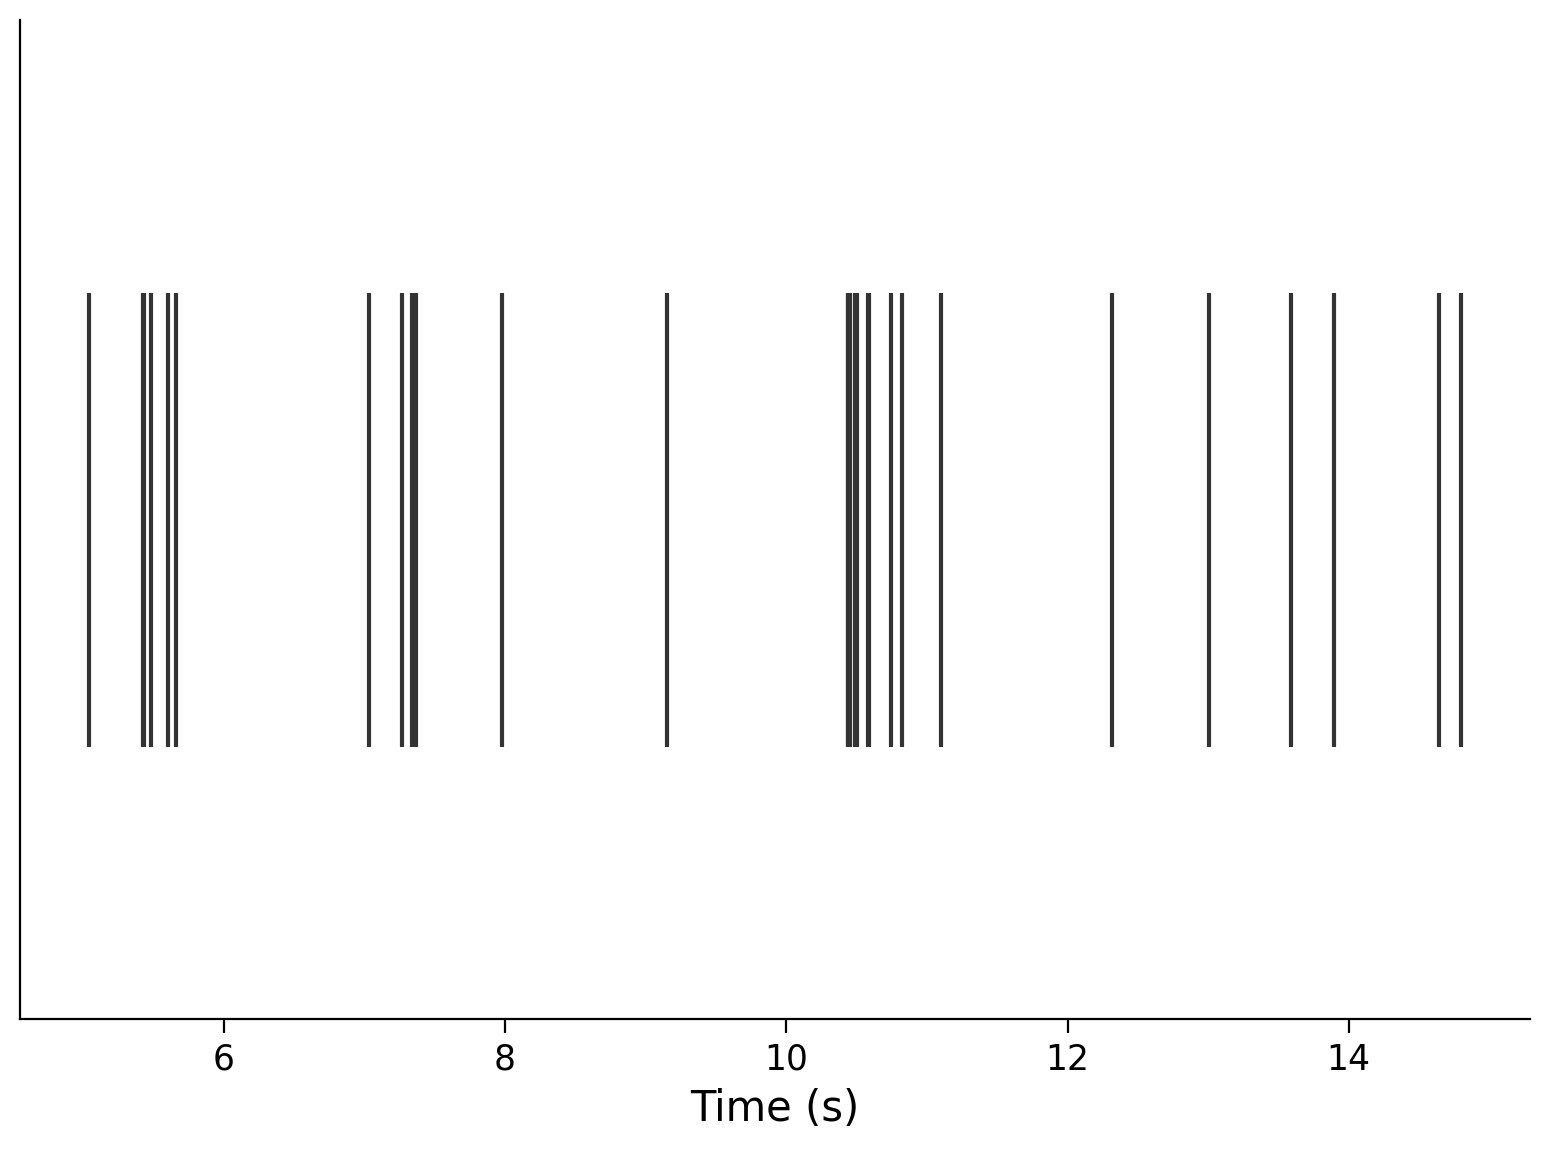

In [ ]:
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

We can also plot multiple neurons. Here are three:

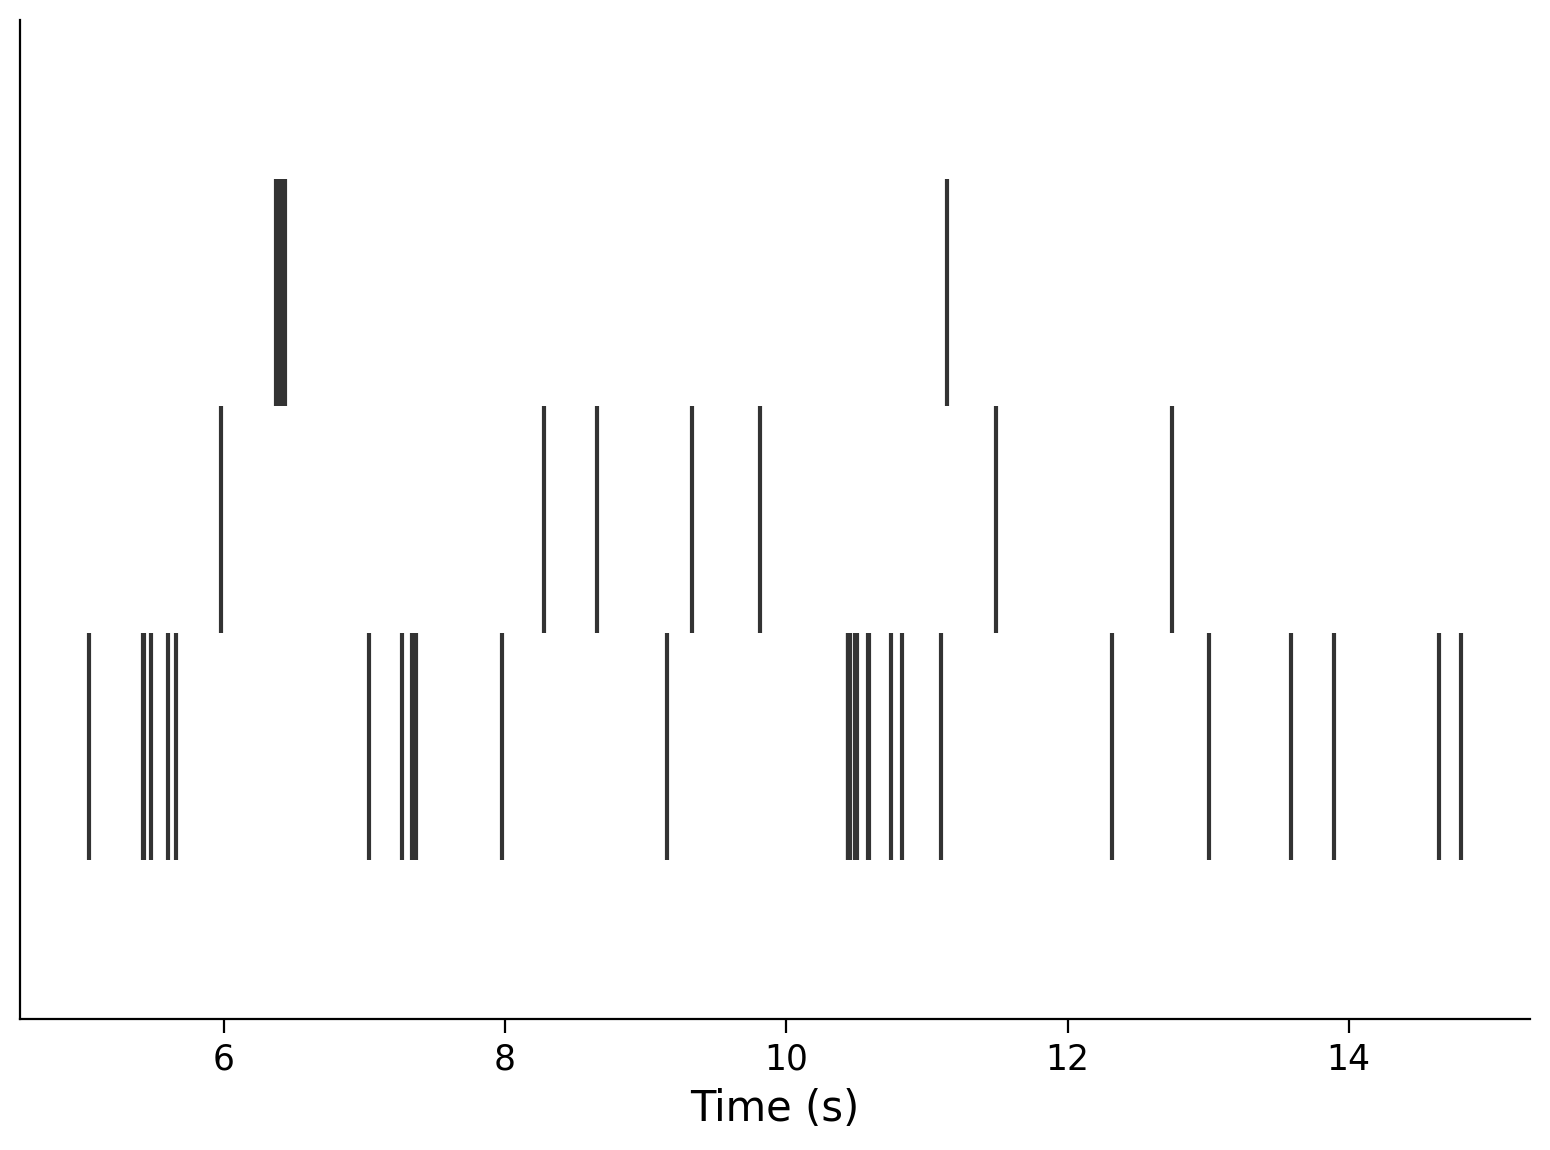

In [ ]:
neuron_idx = [1, 11, 51]
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

This makes a "raster" plot, where the spikes from each neuron appear in a different row.

Plotting a large number of neurons can give you a sense for the characteristics in the population. Let's show every 5th neuron that was recorded:

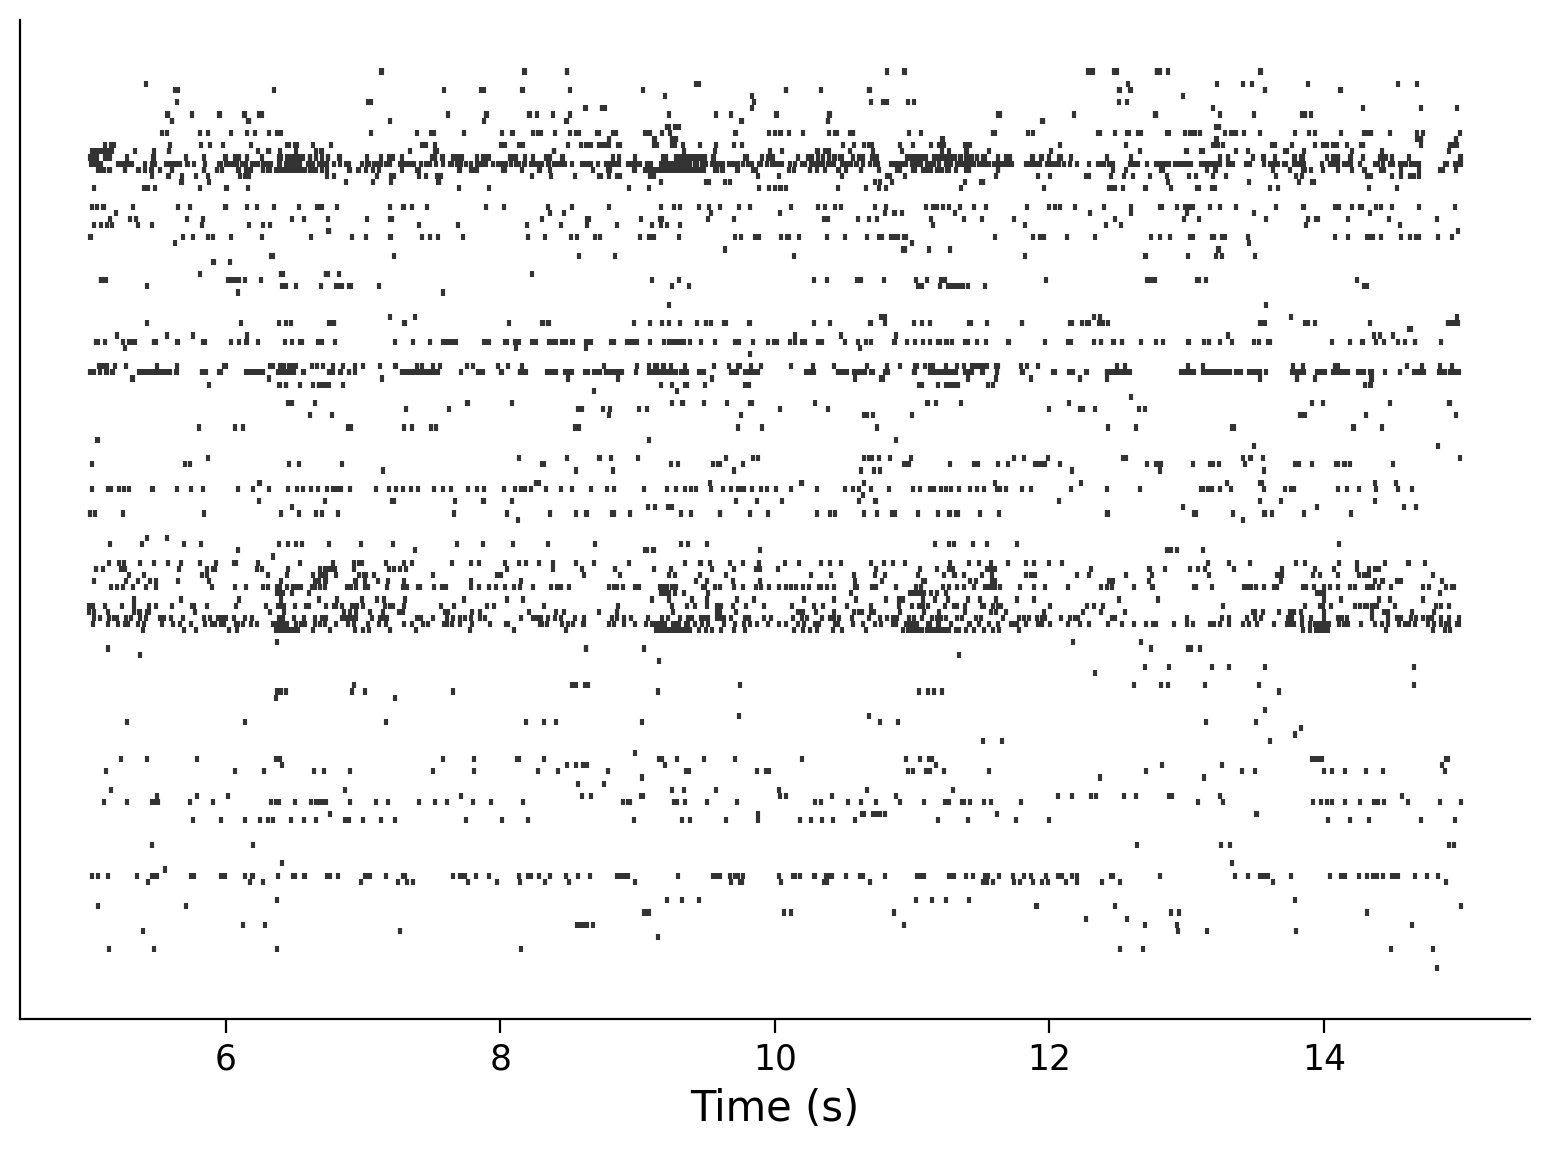

In [ ]:
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

---

# Inter-spike intervals and their distributions

Given the ordered arrays of spike times for each neuron in `spike_times`, which we've just visualized, what can we ask next?

Scientific questions are informed by existing models. So, what knowledge do we already have that can inform questions about this data?

We know that there are physical constraints on neuron spiking. Spiking costs energy, which the neuron's cellular machinery can only obtain at a finite rate. Therefore neurons should have a refractory period: they can only fire as quickly as their metabolic processes can support, and there is a minimum delay between consecutive spikes of the same neuron.

More generally, we can ask "how long does a neuron wait to spike again?" or "what is the longest a neuron will wait?" Can we transform spike times into something else, to address questions like these more directly?

We can consider the inter-spike times (or interspike intervals: ISIs). These are simply the time differences between consecutive spikes of the same neuron.

### Plot the distribution of ISIs for a single neuron

Do this in three steps:

1. Extract the spike times for one of the neurons
2. Compute the ISIs (the amount of time between spikes, or equivalently, the difference between adjacent spike times)
3. Plot a histogram with the array of individual ISIs

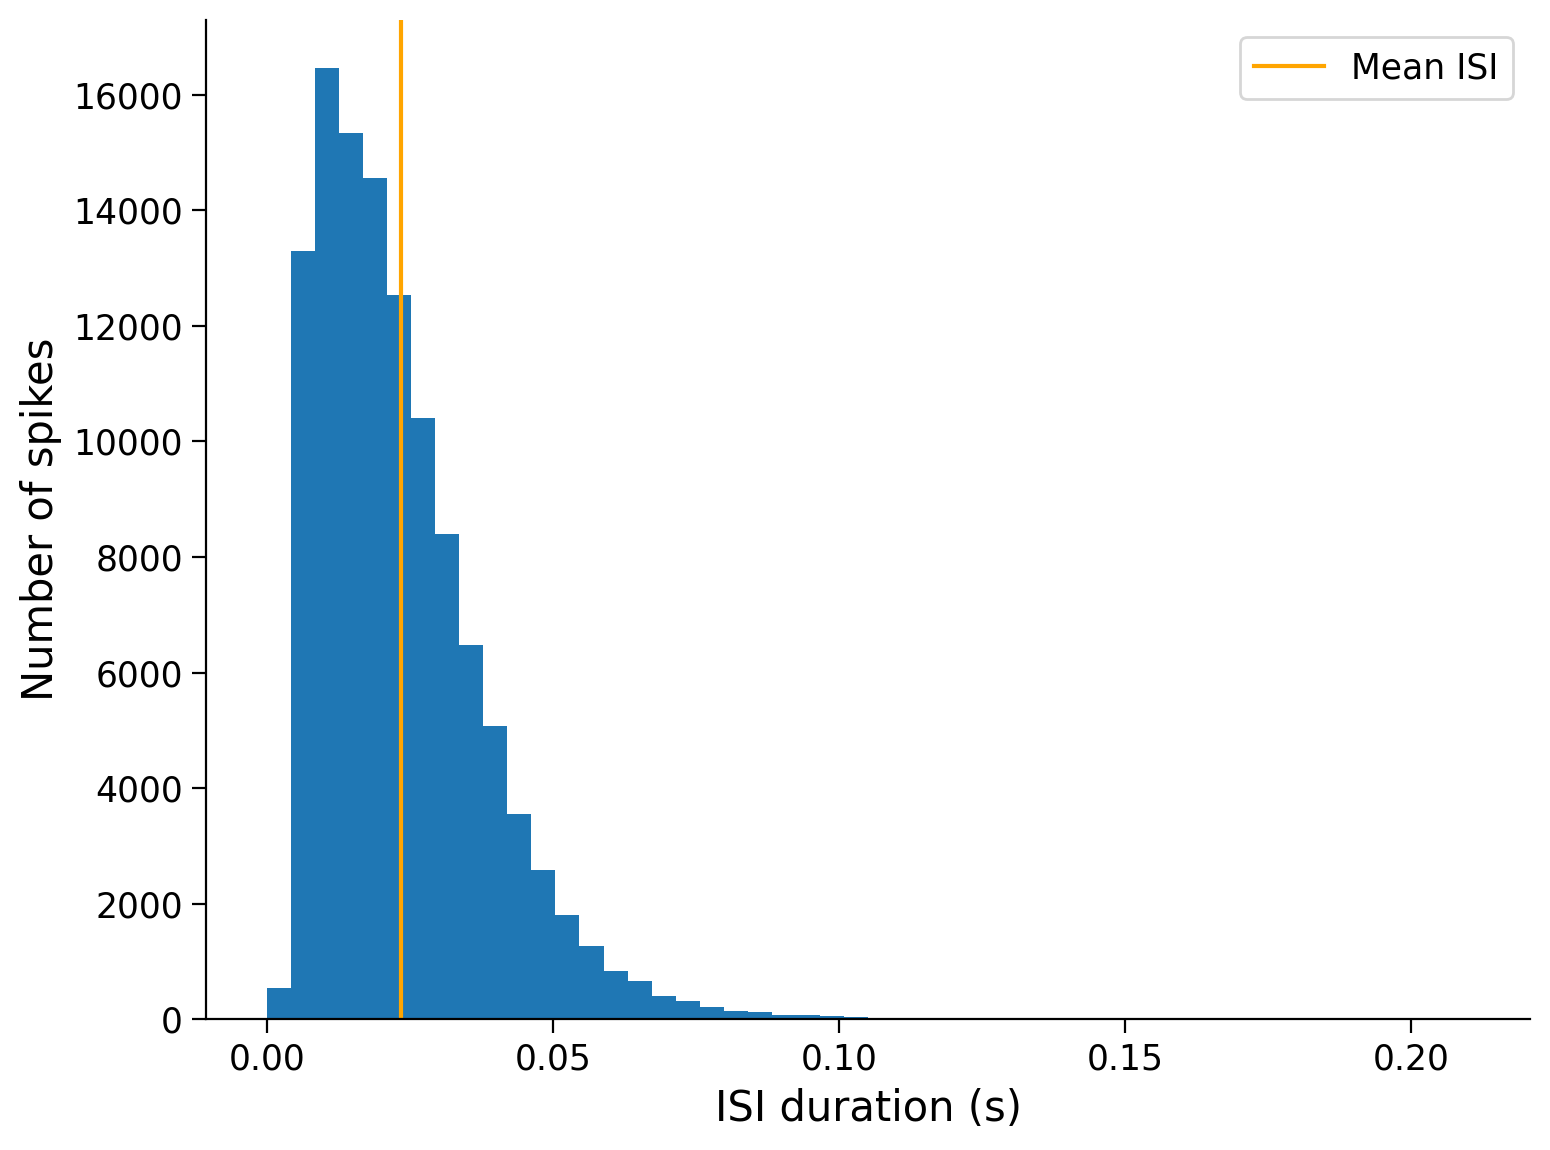

In [ ]:
def compute_single_neuron_isis(spike_times, neuron_idx):
  """Compute a vector of ISIs for a single neuron given spike times.

  Args:
    spike_times (list of 1D arrays): Spike time dataset, with the first
      dimension corresponding to different neurons.
    neuron_idx (int): Index of the unit to compute ISIs for.

  Returns:
    isis (1D array): Duration of time between each spike from one neuron.
  """

  # Extract the spike times for the specified neuron
  single_neuron_spikes = spike_times[neuron_idx]

  # Compute the ISIs for this set of spikes
  # Hint: the function np.diff computes discrete differences along an array
  isis = np.diff(single_neuron_spikes)

  return isis

# Compute ISIs
single_neuron_isis = compute_single_neuron_isis(spike_times, neuron_idx=283)

# Visualize ISIs
plot_isis(single_neuron_isis)

In general, the shorter ISIs are predominant, with counts decreasing rapidly (and smoothly, more or less) with increasing ISI. However, counts also rapidly decrease to zero with _decreasing_ ISI below the maximum of the distribution (8-11 ms). The absence of these very low ISIs agrees with the refractory period hypothesis: the neuron cannot fire quickly enough to populate this region of the ISI distribution.

Check the distributions of some other neurons. To resolve various features of the distributions, you might need to play with the value of `bins` in the call to `plt.hist`. Using too few bins might smooth over interesting details, but if you use too many bins, the random variability will start to dominate.

You might also want to restrict the range to see the shape of the distribution when focusing on relatively short or long ISIs. *Hint:* `plt.hist` takes a `range` argument

---

# What is the functional form of an ISI distribution?

The ISI histograms seem to follow continuous, monotonically decreasing functions above their maxima. The function is clearly non-linear. Could it belong to a single family of functions?

To motivate the idea of using a mathematical function to explain physiological phenomena, let's define a few different function forms that we might expect the relationship to follow: exponential, inverse, and linear.

In [ ]:
def exponential(xs, scale, rate, x0):
  """A simple parameterized exponential function, applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    scale (float): Linear scaling factor.
    rate (float): Exponential growth (positive) or decay (negative) rate.
    x0 (float): Horizontal offset.

  """
  ys = scale * np.exp(rate * (xs - x0))
  return ys

def inverse(xs, scale, x0):
  """A simple parameterized inverse function (`1/x`), applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    scale (float): Linear scaling factor.
    x0 (float): Horizontal offset.

  """
  ys = scale / (xs - x0)
  return ys

def linear(xs, slope, y0):
  """A simple linear function, applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    slope (float): Slope of the line.
    y0 (float): y-intercept of the line.

  """
  ys = slope * xs + y0
  return ys

### Interactive Demo: ISI functions explorer

Here is an interactive demo where you can vary the parameters of these functions and see how well the resulting outputs correspond to the data. Adjust the parameters by moving the sliders and see how close you can get the lines to follow the falling curve of the histogram. This will give you a taste of what you're trying to do when you *fit a model* to data.

"Interactive demo" cells have hidden code that defines an interface where you can play with the parameters of some function using sliders. You don't need to worry about how the code works – but you do need to **run the cell** to enable the sliders.

- Which type of function (exponential/inverse/linear) can you make match the data best?


In [ ]:
#@markdown Be sure to run this cell to enable the demo
# Don't worry about understanding this code! It's to setup an interactive plot.
single_neuron_idx = 283
single_neuron_spikes = spike_times[single_neuron_idx]
single_neuron_isis = np.diff(single_neuron_spikes)

counts, edges = np.histogram(
  single_neuron_isis,
  bins=50,
  range=(0, single_neuron_isis.max())
)

functions = dict(
  exponential=exponential,
  inverse=inverse,
  linear=linear,
)

colors = dict(
  exponential="C1",
  inverse="C2",
  linear="C4",
)

@widgets.interact(
  exp_scale=widgets.FloatSlider(1000, min=0, max=20000, step=250),
  exp_rate=widgets.FloatSlider(-10, min=-200, max=50, step=1),
  exp_x0=widgets.FloatSlider(0.1, min=-0.5, max=0.5, step=0.005),
  inv_scale=widgets.FloatSlider(1000, min=0, max=3e2, step=10),
  inv_x0=widgets.FloatSlider(0, min=-0.2, max=0.2, step=0.01),
  lin_slope=widgets.FloatSlider(-1e5, min=-6e5, max=1e5, step=10000),
  lin_y0=widgets.FloatSlider(10000, min=0, max=4e4, step=1000),
)
def fit_plot(
  exp_scale=1000, exp_rate=-10, exp_x0=0.1,
  inv_scale=1000, inv_x0=0,
  lin_slope=-1e5, lin_y0=2000,
):
  """Helper function for plotting function fits with interactive sliders."""
  func_params = dict(
    exponential=(exp_scale, exp_rate, exp_x0),
    inverse=(inv_scale, inv_x0),
    linear=(lin_slope, lin_y0),
  )
  f, ax = plt.subplots()
  ax.fill_between(edges[:-1], counts, step="post", alpha=.5)
  xs = np.linspace(1e-10, edges.max())
  for name, function in functions.items():
    ys = function(xs, *func_params[name])
    ax.plot(xs, ys, lw=3, color=colors[name], label=name);
  ax.set(
      xlim=(edges.min(), edges.max()),
      ylim=(0, counts.max() * 1.1),
      xlabel="ISI (s)",
      ylabel="Number of spikes",
  )
  ax.legend()
  plt.show()

interactive(children=(FloatSlider(value=1000.0, description='exp_scale', max=20000.0, step=250.0), FloatSlider…

---
# Summary

We loaded some neural data and poked at it to understand how the dataset is organized. Then we made some basic plots to visualize (1) the average level of activity across the population and (2) the distribution of ISIs for an individual neuron. In the very last bit, we started to think about using mathematical formalisms to understand or explain some physiological phenomenon. All of this only allowed us to understand "What" the data looks like.

# The "How" perspective

(based on [Tutorial](https://compneuro.neuromatch.io/tutorials/W1D1_ModelTypes/student/W1D1_Intro.html) by the Neuromatch Academy)

---
# Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Plotting Functions

def histogram(counts, bins, vlines=(), ax=None, ax_args=None, **kwargs):
  """Plot a step histogram given counts over bins."""
  if ax is None:
    _, ax = plt.subplots()

  # duplicate the first element of `counts` to match bin edges
  counts = np.insert(counts, 0, counts[0])

  ax.fill_between(bins, counts, step="pre", alpha=0.4, **kwargs)  # area shading
  ax.plot(bins, counts, drawstyle="steps", **kwargs)  # lines

  for x in vlines:
    ax.axvline(x, color='r', linestyle='dotted')  # vertical line

  if ax_args is None:
    ax_args = {}

  # heuristically set max y to leave a bit of room
  ymin, ymax = ax_args.get('ylim', [None, None])
  if ymax is None:
    ymax = np.max(counts)
    if ax_args.get('yscale', 'linear') == 'log':
      ymax *= 1.5
    else:
      ymax *= 1.1
      if ymin is None:
        ymin = 0

  if ymax == ymin:
    ymax = None

  ax_args['ylim'] = [ymin, ymax]

  ax.set(**ax_args)
  ax.autoscale(enable=False, axis='x', tight=True)

def plot_neuron_stats(v, spike_times):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

  # membrane voltage trace
  ax1.plot(v[0:100])
  ax1.set(xlabel='Time', ylabel='Voltage')
  # plot spike events
  for x in spike_times:
    if x >= 100:
      break
    ax1.axvline(x, color='red')

  # ISI distribution
  if len(spike_times)>1:
    isi = np.diff(spike_times)
    n_bins = np.arange(isi.min(), isi.max() + 2) - .5
    counts, bins = np.histogram(isi, n_bins)
    vlines = []
    if len(isi) > 0:
      vlines = [np.mean(isi)]
    xmax = max(20, int(bins[-1])+5)
    histogram(counts, bins, vlines=vlines, ax=ax2, ax_args={
      'xlabel': 'Inter-spike interval',
      'ylabel': 'Number of intervals',
      'xlim': [0, xmax]
    })
  else:
    ax2.set(xlabel='Inter-spike interval',
           ylabel='Number of intervals')
  plt.show()

---
# The Linear Integrate-and-Fire Neuron

How does a neuron spike?

A neuron charges and discharges an electric field across its cell membrane. The state of this electric field can be described by the _membrane potential_. The membrane potential rises due to excitation of the neuron, and when it reaches a threshold a spike occurs. The potential resets, and must rise to a threshold again before the next spike occurs.

One of the simplest models of spiking neuron behavior is the linear integrate-and-fire model neuron. In this model, the neuron increases its membrane potential $V_m$ over time in response to excitatory input currents $I$ scaled by some factor $\alpha$:

\begin{equation}
dV_m = {\alpha}I
\end{equation}

Once $V_m$ reaches a threshold value a spike is produced, $V_m$ is reset to a starting value, and the process continues.

Here, we will take the starting and threshold potentials as $0$ and $1$, respectively. So, for example, if $\alpha I=0.1$ is constant---that is, the input current is constant---then $dV_m=0.1$, and at each timestep the membrane potential $V_m$ increases by $0.1$ until after $(1-0)/0.1 = 10$ timesteps it reaches the threshold and resets to $V_m=0$, and so on.

Note that we define the membrane potential $V_m$ as a scalar: a single real (or floating point) number. However, a biological neuron's membrane potential will not be exactly constant at all points on its cell membrane at a given time. We could capture this variation with a more complex model (e.g. with more numbers). Do we need to?

The proposed model is a 1D simplification. There are many details we could add to it, to preserve different parts of the complex structure and dynamics of a real neuron. If we were interested in small or local changes in the membrane potential, our 1D simplification could be a problem. However, we'll assume an idealized "point" neuron model for our current purpose.

#### Spiking Inputs

Given our simplified model for the neuron dynamics, we still need to consider what form the input $I$ will take. How should we specify the firing behavior of the presynaptic neuron(s) providing the inputs to our model neuron?

Unlike in the simple example above, where $\alpha I=0.1$, the input current is generally not constant. Physical inputs tend to vary with time. We can describe this variation with a distribution.

We'll assume the input current $I$ over a timestep is due to equal contributions from a non-negative ($\ge 0$) integer number of input spikes arriving in that timestep. Our model neuron might integrate currents from 3 input spikes in one timestep, and 7 spikes in the next timestep. We should see similar behavior when sampling from our distribution.

Given no other information about the input neurons, we will also assume that the distribution has a mean (i.e. mean rate, or number of spikes received per timestep), and that the spiking events of the input neuron(s) are independent in time. Are these reasonable assumptions in the context of real neurons?

A suitable distribution given these assumptions is the Poisson distribution, which we'll use to model $I$:

\begin{equation}
I \sim \mathrm{Poisson}(\lambda)
\end{equation}

where $\lambda$ is the mean of the distribution: the average rate of spikes received per timestep.

## Computing $dV_m$

For your first exercise, you will write the code to compute the change in voltage $dV_m$ (per timestep) of the linear integrate-and-fire model neuron. The rest of the code to handle numerical integration is provided for you, so you just need to fill in a definition for `dv` in the `lif_neuron` function below. The value of $\lambda$ for the Poisson random variable is given by the function argument `rate`.



The [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html) package is a great resource for working with and sampling from various probability distributions. We will use the `scipy.stats.poisson` class and its method `rvs` to produce Poisson-distributed random samples. In this tutorial, we have imported this package with the alias `stats`, so you should refer to it in your code as `stats.poisson`.

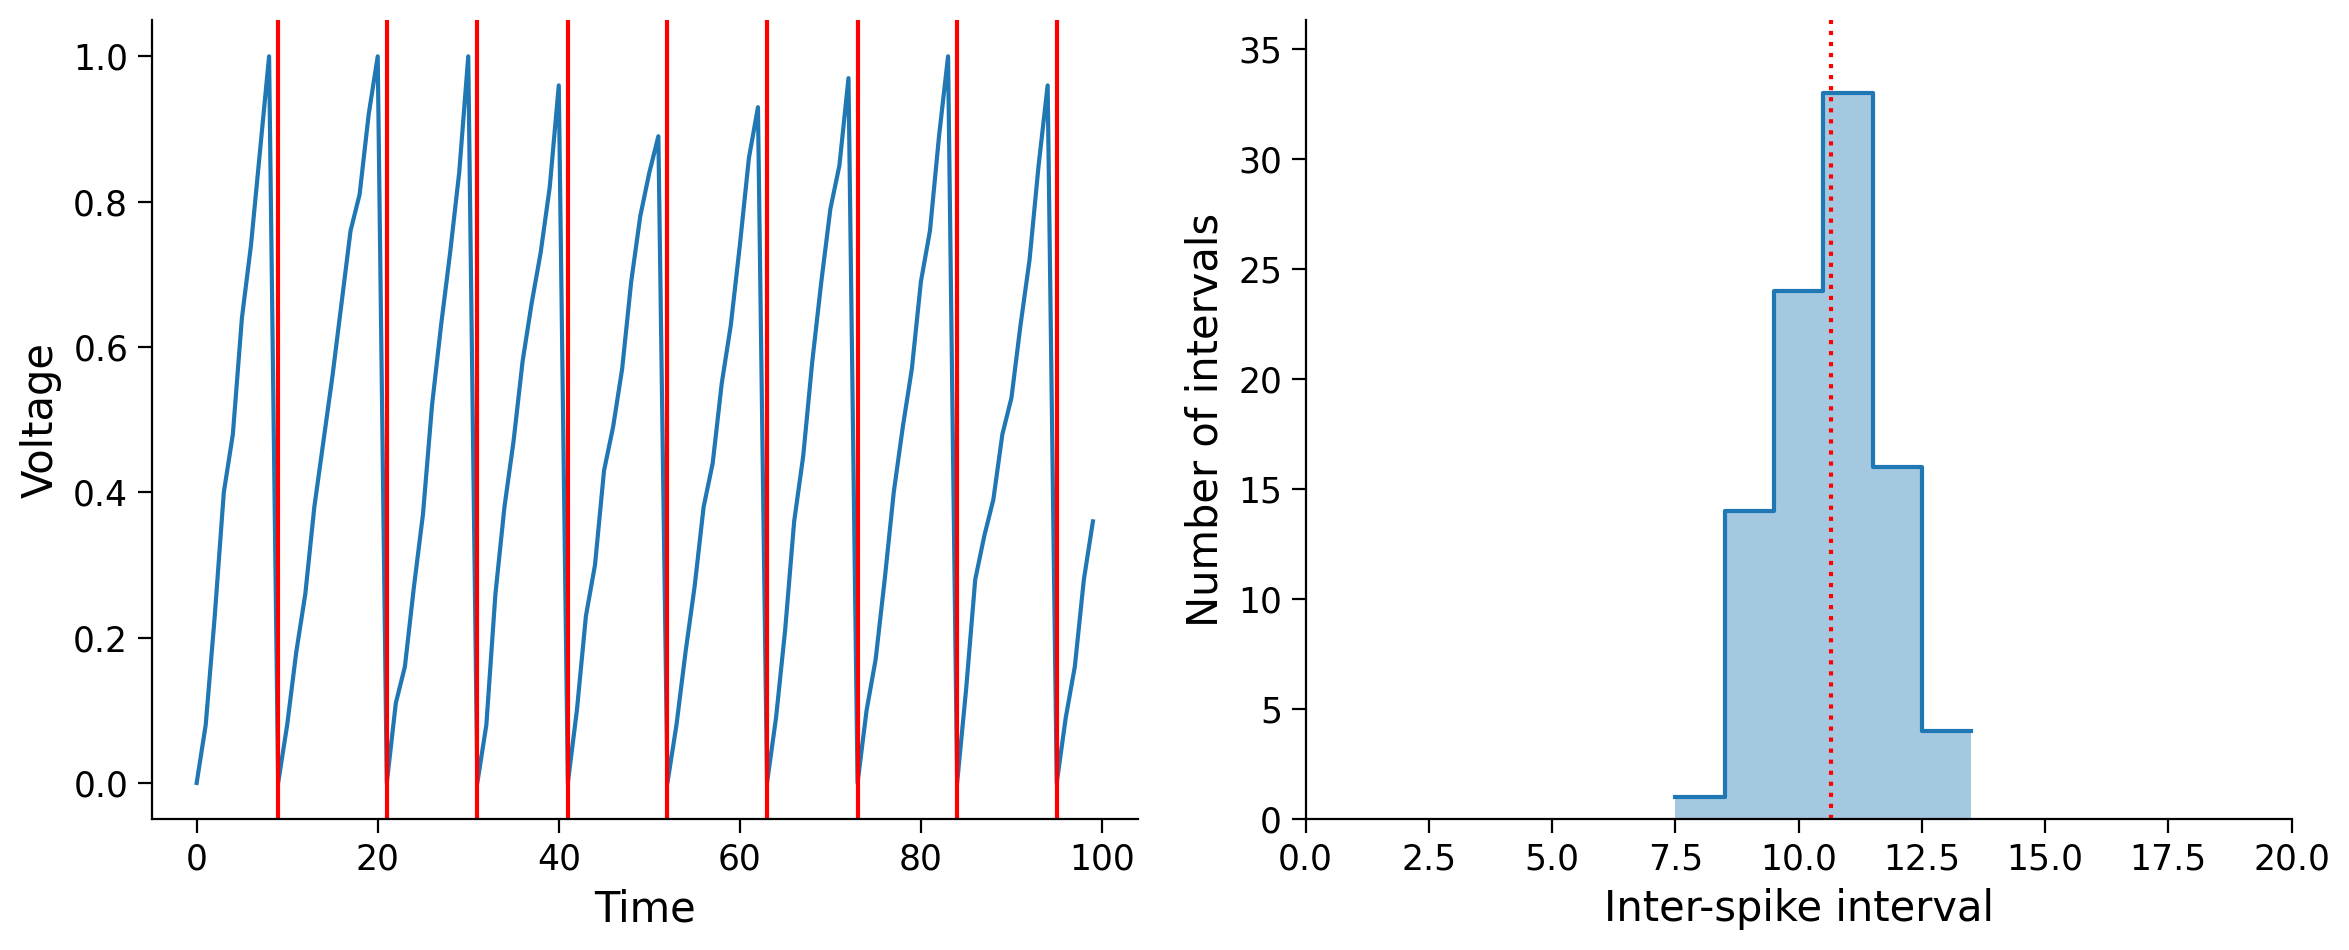

In [ ]:
def lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  """ Simulate a linear integrate-and-fire neuron.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    rate (int): The mean rate of incoming spikes

  """
  # Precompute Poisson samples for speed
  exc = stats.poisson(rate).rvs(n_steps)

  # Initialize voltage and spike storage
  v = np.zeros(n_steps)
  spike_times = []

  # Loop over steps
  for i in range(1, n_steps):

    # Update v
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv

    # If spike happens, reset voltage and record
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron()

# Visualize
plot_neuron_stats(v, spike_times)

## Interactive Demo: Linear-IF neuron
Like last time, you can now explore how various parameters of the LIF model influence the ISI distribution. Specifically, you can vary `alpha`, which is input scaling factor, and `rate`, which is the mean rate of incoming spikes.


1.   What is the spiking pattern of this model?
2.   What effect does raising or lowering alpha have?
3.   What effect does raising or lowering the rate have?
4.   Does the distribution of ISIs ever look like what you observed in the data in the "What" part?


In [ ]:
# @markdown You don't need to worry about how the code works – but you do need to **run the cell** to enable the sliders.

def _lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  exc = stats.poisson(rate).rvs(n_steps)
  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0
  return v, spike_times

@widgets.interact(
  alpha=widgets.FloatLogSlider(0.01, min=-2, max=-1),
  rate=widgets.IntSlider(10, min=5, max=20)
)
def plot_lif_neuron(alpha=0.01, rate=10):
  v, spike_times = _lif_neuron(2000, alpha, rate)

  plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=0.01, description='alpha', max=-1.0, min=-2.0), IntSlider(value=10,…

---
# Inhibitory signals


Our linear integrate-and-fire neuron from the previous section was indeed able to produce spikes. However, our ISI histogram doesn't look much like empirical ISI histograms seen in Tutorial 1, which had an exponential-like shape. What is our model neuron missing, given that it doesn't behave like a real neuron?

In the previous model we only considered excitatory behavior -- the only way the membrane potential could decrease was upon a spike event. We know, however, that there are other factors that can drive $V_m$ down. First is the natural tendency of the neuron to return to some steady state or resting potential. We can update our previous model as follows:

\begin{equation}
dV_m = -{\beta}V_m + {\alpha}I
\end{equation}

where $V_m$ is the current membrane potential and $\beta$ is some leakage factor. This is a basic form of the popular Leaky Integrate-and-Fire model neuron (for a more detailed discussion of the LIF Neuron, see Bonus Section 2 and the Biological Neuron Models day later in this course).

We also know that in addition to excitatory presynaptic neurons, we can have inhibitory presynaptic neurons as well. We can model these inhibitory neurons with another Poisson random variable:

\begin{align}
I &= I_{\mathrm{exc}} - I_{\mathrm{inh}} \\
I_{\mathrm{exc}} &\sim \mathrm{Poisson}(\lambda_{\mathrm{exc}}) \\
I_{\mathrm{inh}} &\sim \mathrm{Poisson}(\lambda_{\mathrm{inh}})
\end{align}

where $\lambda_{\mathrm{exc}}$ and $\lambda_{\mathrm{inh}}$ are the average spike rates (per timestep) of the excitatory and inhibitory presynaptic neurons, respectively.

### Computing $dV_m$ with inhibitory signals

For your second exercise, you will again write the code to compute the change in voltage $dV_m$, though now of the LIF model neuron described above. Like last time, the rest of the code needed to handle the neuron dynamics are provided for you, so you just need to fill in a definition for `dv` below.


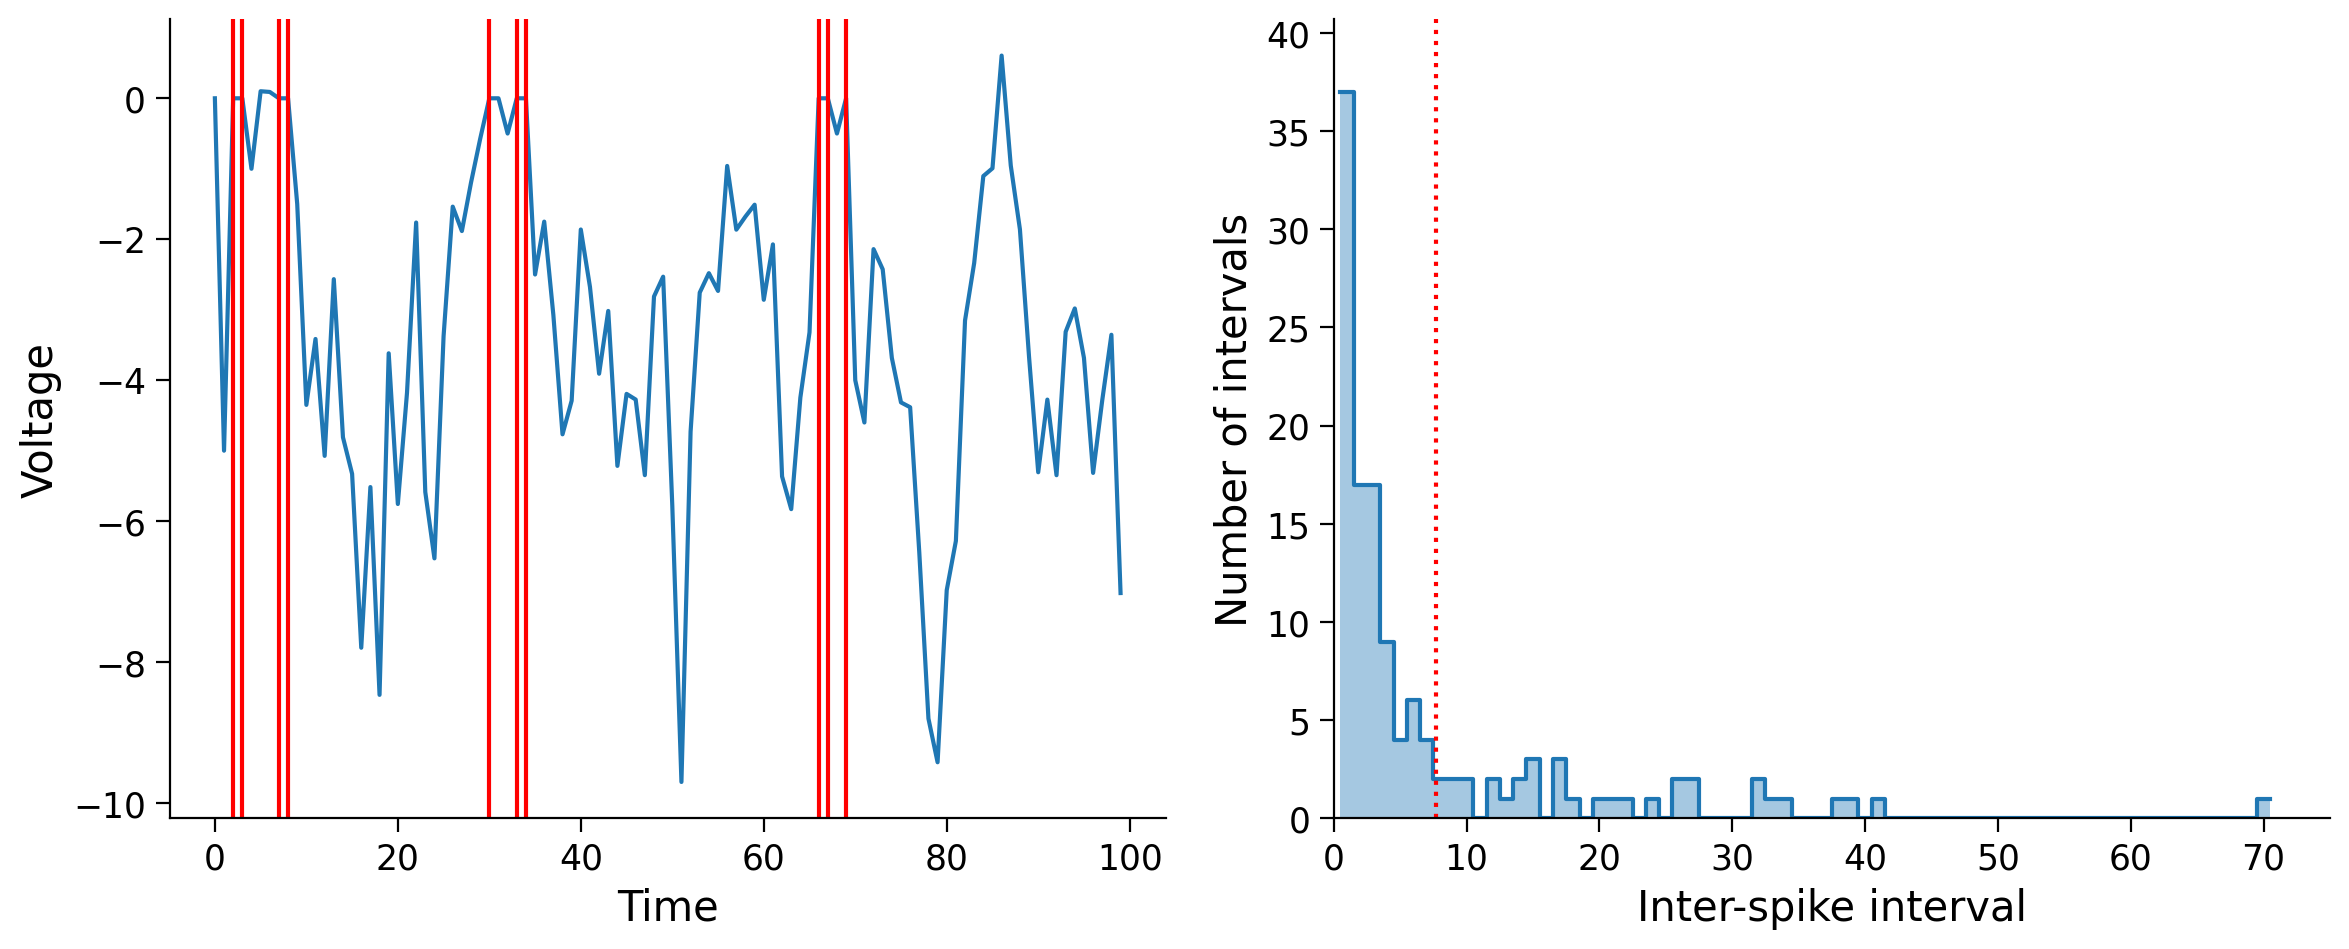

In [ ]:
def lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """

  # precompute Poisson samples for speed
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []

  for i in range(1, n_steps):

    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])

    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron_inh()

# Visualize
plot_neuron_stats(v, spike_times)

## Interactive Demo: LIF + inhibition neuron

As in the previous Interactive Demo, you can play with the parameters of the input to our LIF neuron and visualize what happens. Here, in addition to controlling `alpha`, which scales the input, you can also control `beta`, which is a leakage factor on the voltage, `exc_rate`, which is the mean rate of the excitatory presynaptic neurons, and `inh_rate`, which is the mean rate of the inhibitory presynaptic neurons.

1.   What effect does raising the excitatory rate have?
2.   What effect does raising the inhibitory rate have?
3.   What if you raise both the excitatory and inhibitory rate?
4.   Does the distribution of ISIs ever look like what you observed in the data in the "What" part?


In [ ]:
#@title
#@markdown **Run the cell** to enable the sliders.
def _lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """
  # precompute Poisson samples for speed
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

@widgets.interact(alpha=widgets.FloatLogSlider(0.5, min=-1, max=1),
                  beta=widgets.FloatLogSlider(0.1, min=-1, max=0),
                  exc_rate=widgets.IntSlider(12, min=10, max=20),
                  inh_rate=widgets.IntSlider(12, min=10, max=20))
def plot_lif_neuron(alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  v, spike_times = _lif_neuron_inh(2000, alpha, beta, exc_rate, inh_rate)
  plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=0.5, description='alpha', max=1.0, min=-1.0), FloatLogSlider(value=…

# Summary

In this tutorial we gained some intuition for the mechanisms that produce the observed behavior in our real neural data. First, we built a simple neuron model with excitatory input and saw that its behavior, measured using the ISI distribution, did not match our real neurons. We then improved our model by adding leakiness and inhibitory input. The behavior of this balanced model was much closer to the real neural data.

---
# Notation

\begin{align}
V_m &\quad \text{membrane potential} \\
dV_m &\quad \text{change in membrane potential}\\
C_m &\quad \text{membrane capacitance}\\
I &\quad \text{input current}\\
R_m &\quad \text{membrane resistance}:\\
V_\mathrm{rest} &\quad \text{resting potential}\\
\alpha &\quad \text{scaling factor for input current}\\
\beta &\quad \text{leakage factor}\\
\lambda &\quad \text{average spike rate}\\
\lambda_\mathrm{exc} &\quad \text{average spike rate for excitatory neurons}\\
\lambda_\mathrm{inh} &\quad \text{average spike rate for inhibitory neurons}\\
\end{align}

# The "Why" perspective

(based on [Tutorial](https://compneuro.neuromatch.io/tutorials/W1D1_ModelTypes/student/W1D1_Intro.html) by the Neuromatch Academy)

---
# Setup

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Plotting Functions

def plot_pmf(pmf,isi_range):
  """Plot the probability mass function."""
  ymax = max(0.2, 1.05 * np.max(pmf))
  pmf_ = np.insert(pmf, 0, pmf[0])
  plt.plot(bins, pmf_, drawstyle="steps")
  plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
  plt.title(f"Neuron {neuron_idx}")
  plt.xlabel("Inter-spike interval (s)")
  plt.ylabel("Probability mass")
  plt.xlim(isi_range)
  plt.ylim([0, ymax])

In [ ]:
#@title Download Data
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Could not download data')
else:
  steinmetz_spikes = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

---
# Optimization and Information

Neurons can only fire so often in a fixed period of time, as the act of emitting a spike consumes energy that is depleted and must eventually be replenished. To communicate effectively for downstream computation, the neuron would need to make good use of its limited spiking capability. This becomes an optimization problem:

What is the optimal way for a neuron to fire in order to maximize its ability to communicate information?

In order to explore this question, we first need to have a quantifiable measure for information. Shannon introduced the concept of entropy to do just that, and defined it as

\begin{equation}
H_b(X) = -\sum_{x\in X} p(x) \log_b p(x)
\end{equation}

where $H$ is entropy measured in units of base $b$ and $p(x)$ is the probability of observing the event $x$ from the set of all possible events in $X$. See the Bonus Section 1 for a more detailed look at how this equation was derived.

The most common base of measuring entropy is $b=2$, so we often talk about *bits* of information, though other bases are used as well (e.g. when $b=e$ we call the units *nats*).

First, let's explore how entropy changes between some simple discrete probability distributions. In the rest of this tutorial we will refer to these as probability mass functions (PMF), where $p(x_i)$ equals the $i^{th}$ value in an array, and mass refers to how much of the distribution is contained at that value.

For our first PMF, we will choose one where all of the probability mass is located in the middle of the distribution.

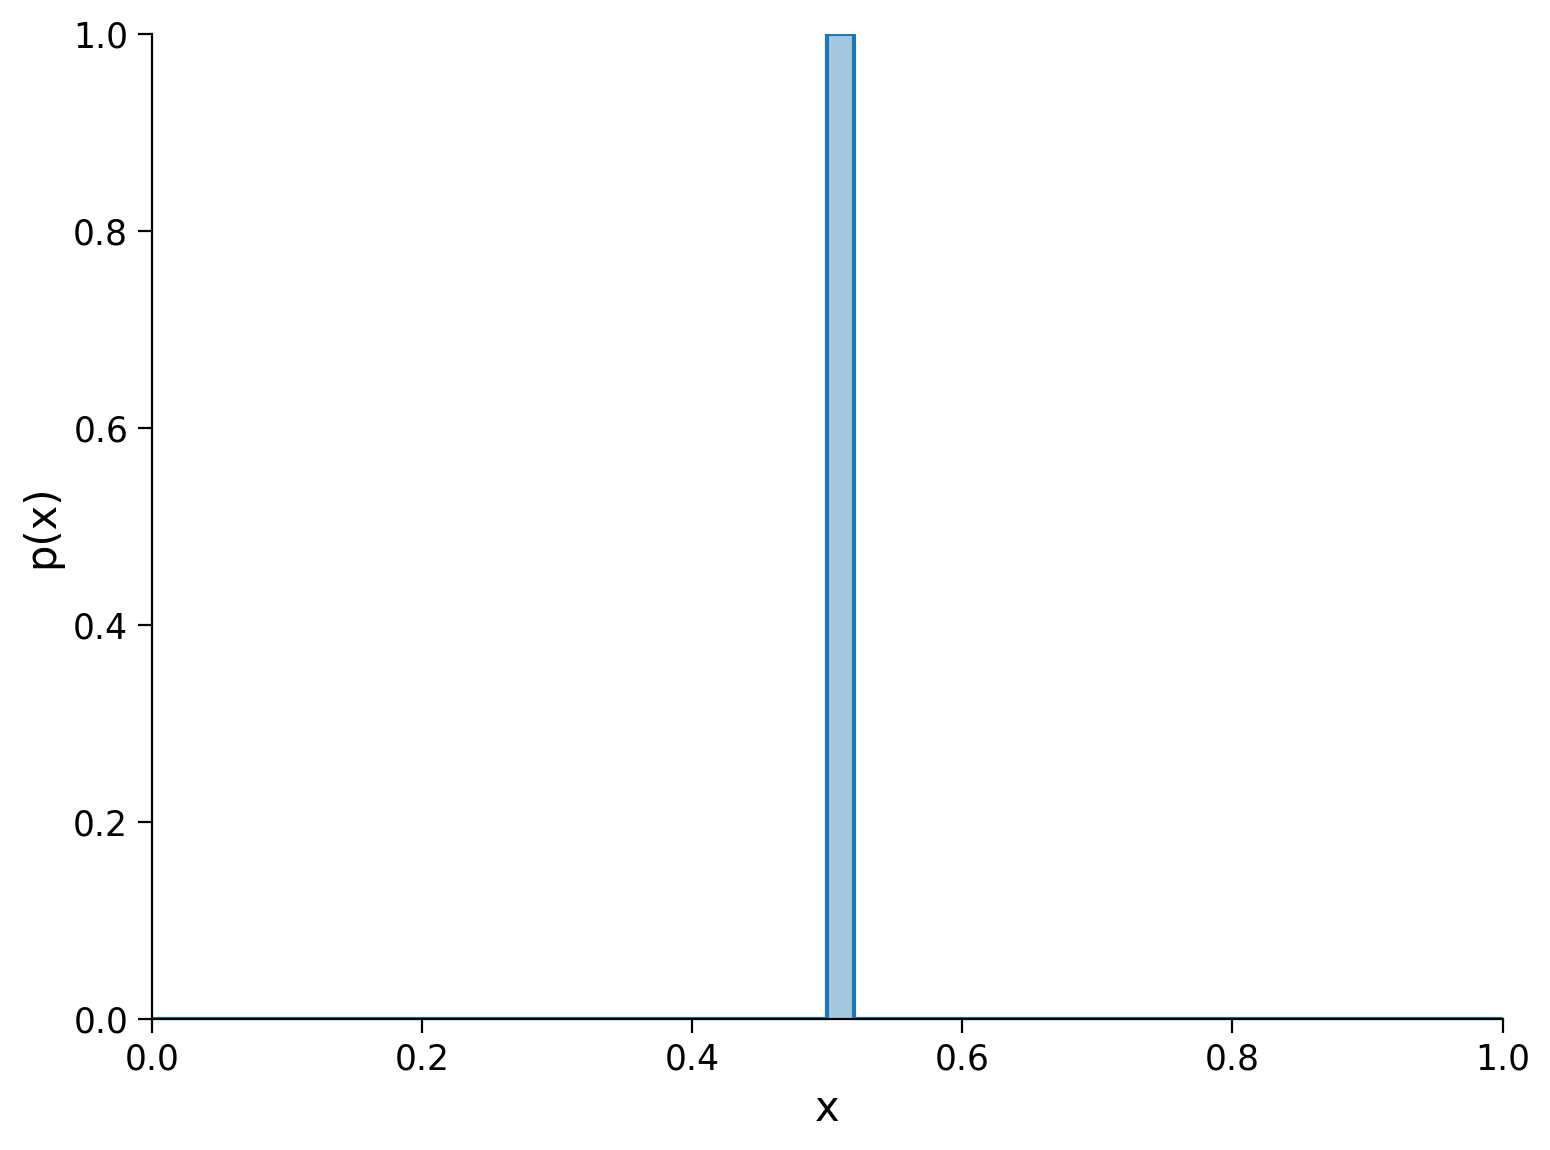

In [ ]:
n_bins = 50  # number of points supporting the distribution
x_range = (0, 1)  # will be subdivided evenly into bins corresponding to points

bins = np.linspace(*x_range, n_bins + 1)  # bin edges

pmf = np.zeros(n_bins)
pmf[len(pmf) // 2] = 1.0  # middle point has all the mass

# Since we already have a PMF, rather than un-binned samples, `plt.hist` is not
# suitable. Instead, we directly plot the PMF as a step function to visualize
# the histogram:
pmf_ = np.insert(pmf, 0, pmf[0])  # this is necessary to align plot steps with bin edges
plt.plot(bins, pmf_, drawstyle="steps")
# `fill_between` provides area shading
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1)
plt.show()

If we were to draw a sample from this distribution, we know exactly what we would get every time. Distributions where all the mass is concentrated on a single event are known as *deterministic*.

How much entropy is contained in a deterministic distribution? We will compute this in the next exercise.

## Computing Entropy

Your first exercise is to implement a method that computes the entropy of a discrete probability distribution, given its mass function. Remember that we are interested in entropy in units of _bits_, so be sure to use the correct log function.

Recall that $\log(0)$ is undefined. When evaluated at $0$, NumPy log functions (such as `np.log2`) return `np.nan` ("Not a Number"). By convention, these undefined terms— which correspond to points in the distribution with zero mass—are excluded from the sum that computes the entropy.

In [ ]:
def entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits.

  This is a measure of information in the distribution. For a totally
  deterministic distribution, where samples are always found in the same bin,
  then samples from the distribution give no more information and the entropy
  is 0.

  For now this assumes `pmf` arrives as a well-formed distribution (that is,
  `np.sum(pmf)==1` and `not np.any(pmf < 0)`)

  Args:
    pmf (np.ndarray): The probability mass function for a discrete distribution
      represented as an array of probabilities.
  Returns:
    h (number): The entropy of the distribution in `pmf`.

  """

  # reduce to non-zero entries to avoid an error from log2(0)
  pmf = pmf[pmf > 0]

  # implement the equation for Shannon entropy (in bits)
  h = -np.sum(pmf * np.log2(pmf))

  # return the absolute value (avoids getting a -0 result)
  return np.abs(h)

# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")

0.00 bits


We expect zero surprise from a deterministic distribution. If we had done this calculation by hand, it would simply be $-1\log_2 1 = -0=0$.

Note that changing the location of the peak (i.e. the point and bin on which all the mass rests) doesn't alter the entropy. The entropy is about how predictable a sample is with respect to a distribution. A single peak is deterministic regardless of which point it sits on - the following plot shows a PMF that would also have zero entropy.

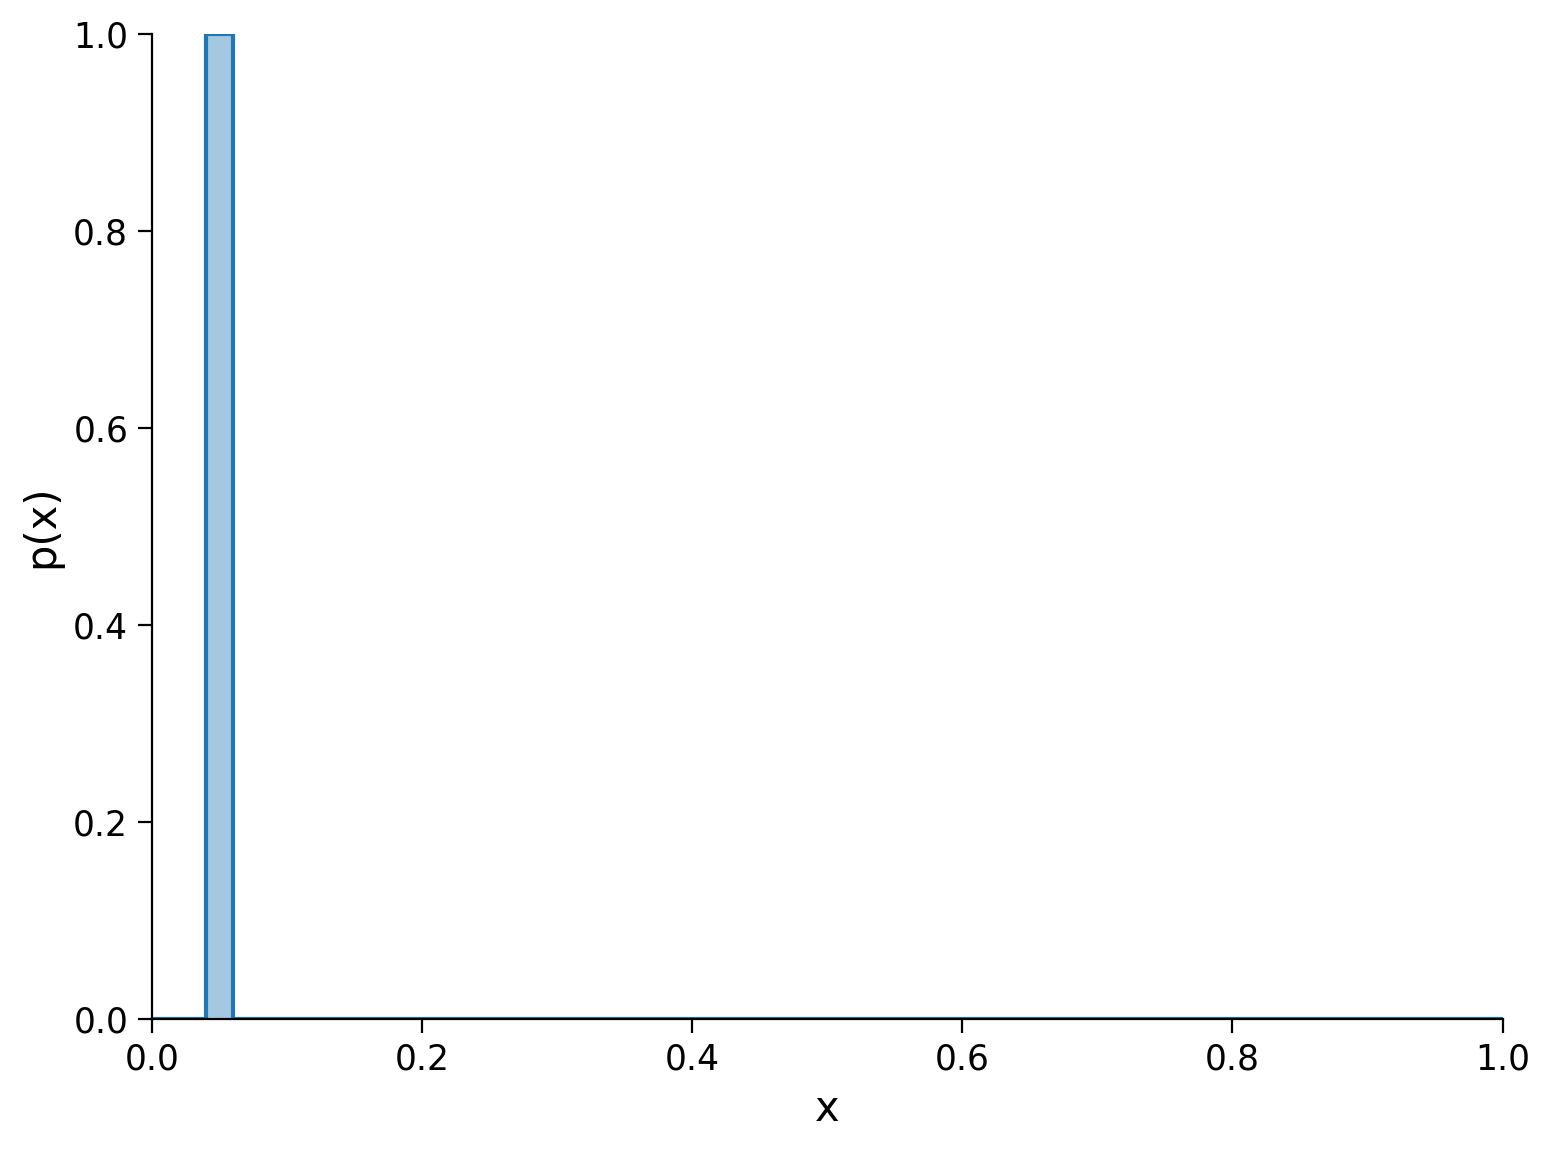

In [ ]:
# @markdown Execute this cell to visualize another PMF with zero entropy
pmf = np.zeros(n_bins)
pmf[2] = 1.0  # arbitrary point has all the mass

pmf_ = np.insert(pmf, 0, pmf[0])
plt.plot(bins, pmf_, drawstyle="steps")
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1);

What about a distribution with mass split equally between two points?

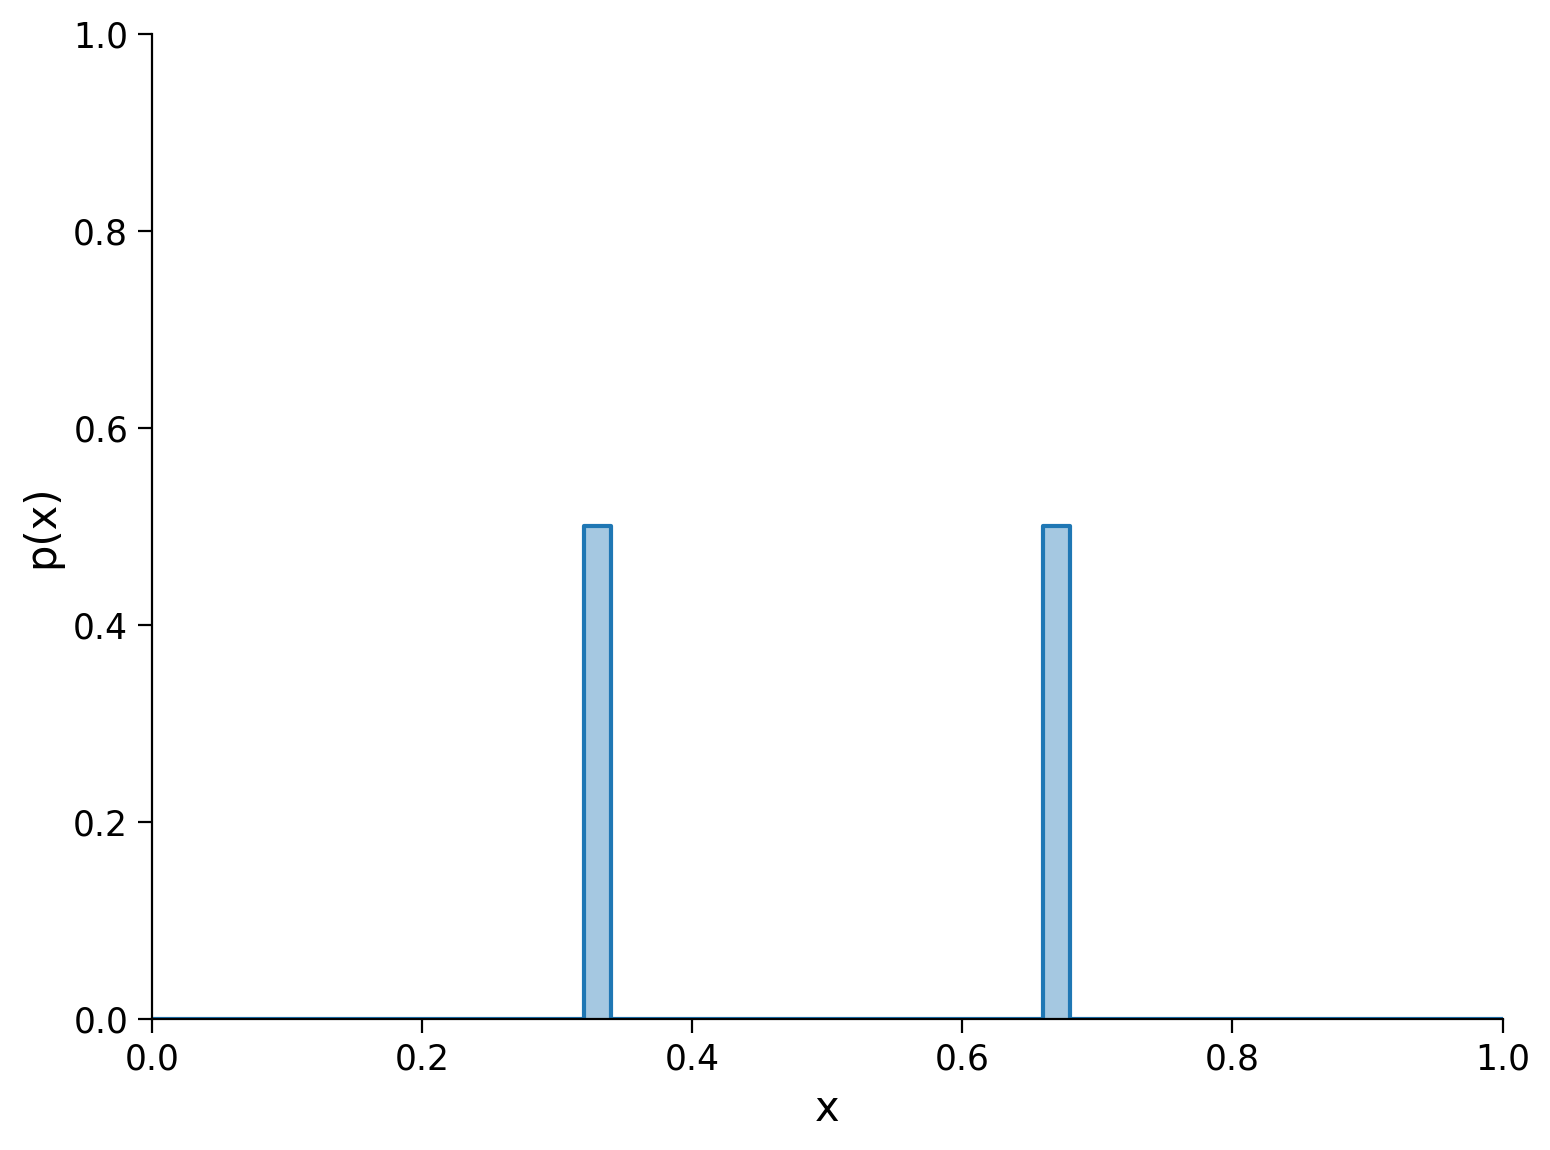

In [ ]:
# @markdown Execute this cell to visualize a PMF with split mass

pmf = np.zeros(n_bins)
pmf[len(pmf) // 3] = 0.5
pmf[2 * len(pmf) // 3] = 0.5

pmf_ = np.insert(pmf, 0, pmf[0])
plt.plot(bins, pmf_, drawstyle="steps")
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1)
plt.show()

Here, the entropy calculation is: $-(0.5 \log_2 0.5 + 0.5\log_2 0.5)=1$

There is 1 bit of entropy. This means that before we take a random sample, there is 1 bit of uncertainty about which point in the distribution the sample will fall on: it will either be the first peak or the second one.

Likewise, if we make one of the peaks taller (i.e. its point holds more of the probability mass) and the other one shorter, the entropy will decrease because of the increased certainty that the sample will fall on one point and not the other: : $-(0.2 \log_2 0.2 + 0.8\log_2 0.8)\approx 0.72$



Try changing the definition of the number and weighting of peaks, and see how the entropy varies.

If we split the probability mass among even more points, the entropy continues to increase. Let's derive the general form for $N$ points of equal mass, where $p_i=p=1/N$:

\begin{align}
-\sum_i p_i \log_b p_i &= -\sum_i^N \frac{1}{N} \log_b \frac{1}{N} \\
&= -\log_b \frac{1}{N} \\
&= \log_b N
\end{align}

If we have $N$ discrete points, the _uniform distribution_ (where all points have equal mass) is the distribution with the highest entropy: $\log_b N$. This upper bound on entropy is useful when considering binning strategies, as any estimate of entropy over $N$ discrete points (or bins) must be in the interval $[0, \log_b N]$.


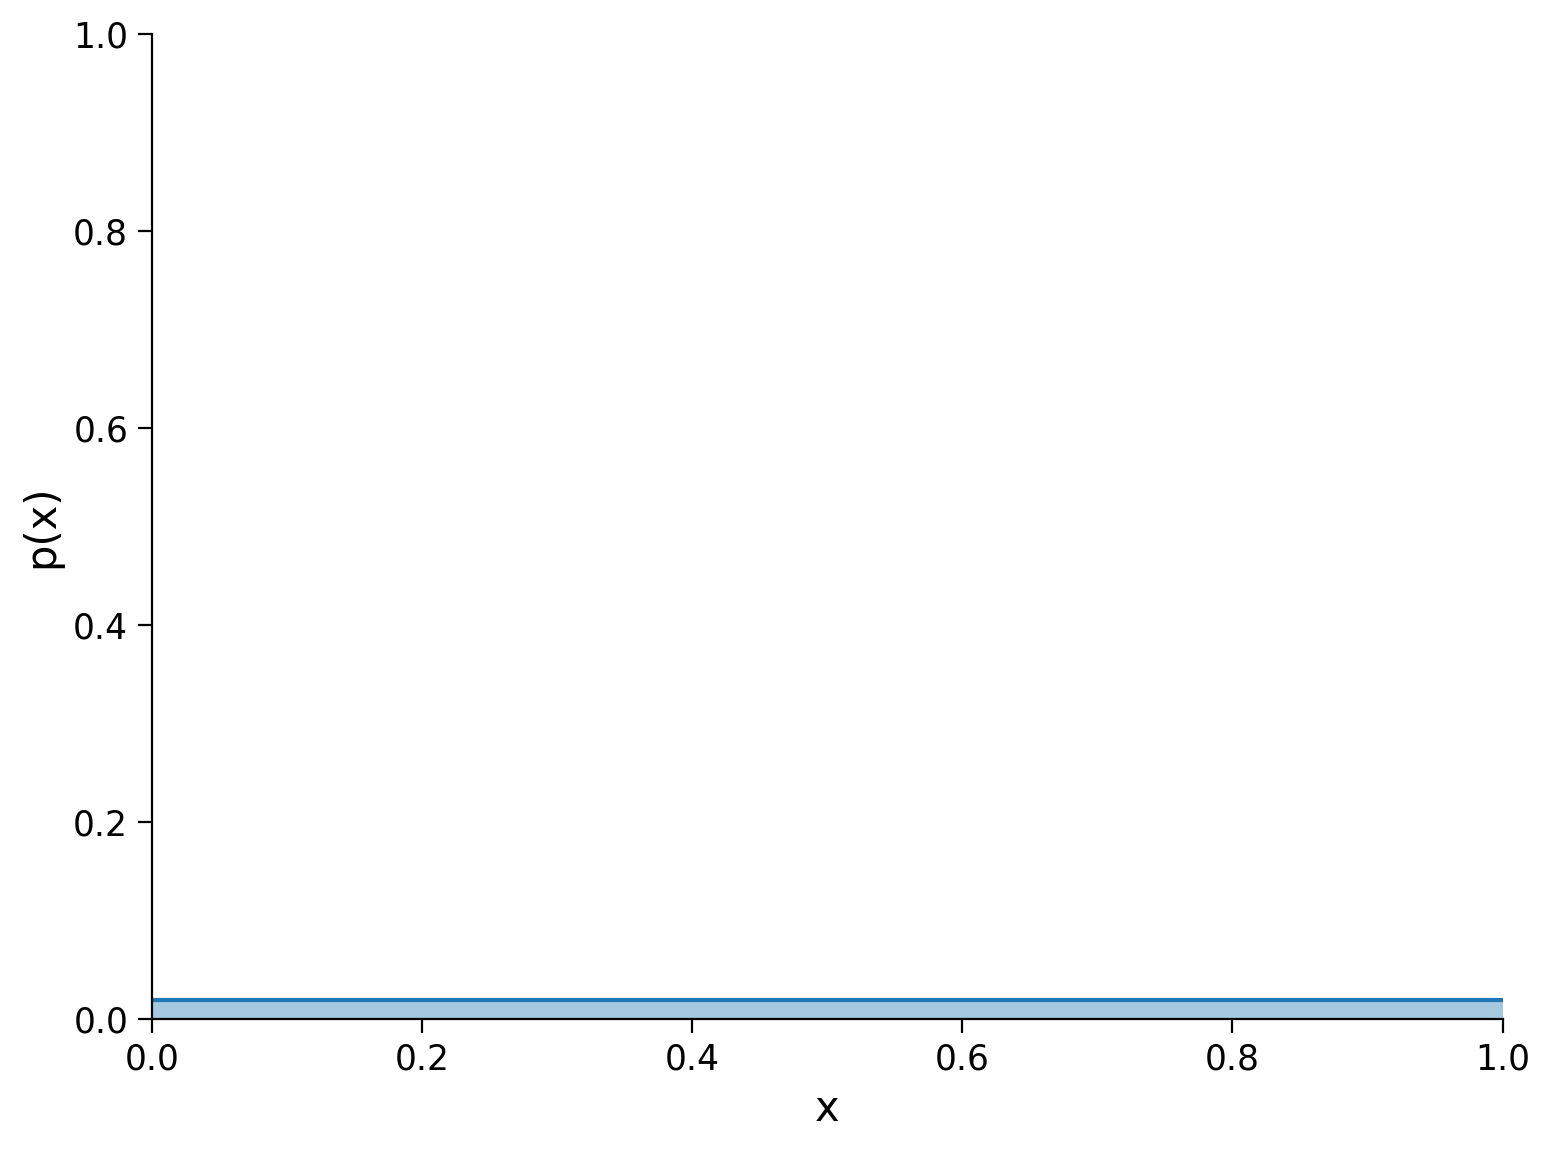

In [ ]:
# @markdown Execute this cell to visualize a PMF of uniform distribution

pmf = np.ones(n_bins) / n_bins  # [1/N] * N

pmf_ = np.insert(pmf, 0, pmf[0])
plt.plot(bins, pmf_, drawstyle="steps")
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1)
plt.show()

Here, there are 50 points and the entropy of the uniform distribution is $\log_2 50\approx 5.64$. If we construct _any_ discrete distribution $X$ over 50 points (or bins) and calculate an entropy of $H_2(X)>\log_2 50$, something must be wrong with our implementation of the discrete entropy computation.

---
# Information, neurons, and spikes

Recall the discussion of spike times and inter-spike intervals (ISIs) from Tutorial 1. What does the information content (or distributional entropy) of these measures say about our theory of nervous systems?

We'll consider three hypothetical neurons that all have the same mean ISI, but with different distributions:

1. Deterministic
2. Uniform
3. Exponential

Fixing the mean of the ISI distribution is equivalent to fixing its inverse: the neuron's mean firing rate. If a neuron has a fixed energy budget and each of its spikes has the same energy cost, then by fixing the mean firing rate, we are normalizing for energy expenditure. This provides a basis for comparing the entropy of different ISI distributions. In other words: if our neuron has a fixed budget, what ISI distribution should it express (all else being equal) to maximize the information content of its outputs?

Let's construct our three distributions and see how their entropies differ.

In [ ]:
n_bins = 50
mean_isi = 0.025
isi_range = (0, 0.25)

bins = np.linspace(*isi_range, n_bins + 1)
mean_idx = np.searchsorted(bins, mean_isi)

# 1. all mass concentrated on the ISI mean
pmf_single = np.zeros(n_bins)
pmf_single[mean_idx] = 1.0

# 2. mass uniformly distributed about the ISI mean
pmf_uniform = np.zeros(n_bins)
pmf_uniform[0:2*mean_idx] = 1 / (2 * mean_idx)

# 3. mass exponentially distributed about the ISI mean
pmf_exp = stats.expon.pdf(bins[1:], scale=mean_isi)
pmf_exp /= np.sum(pmf_exp)

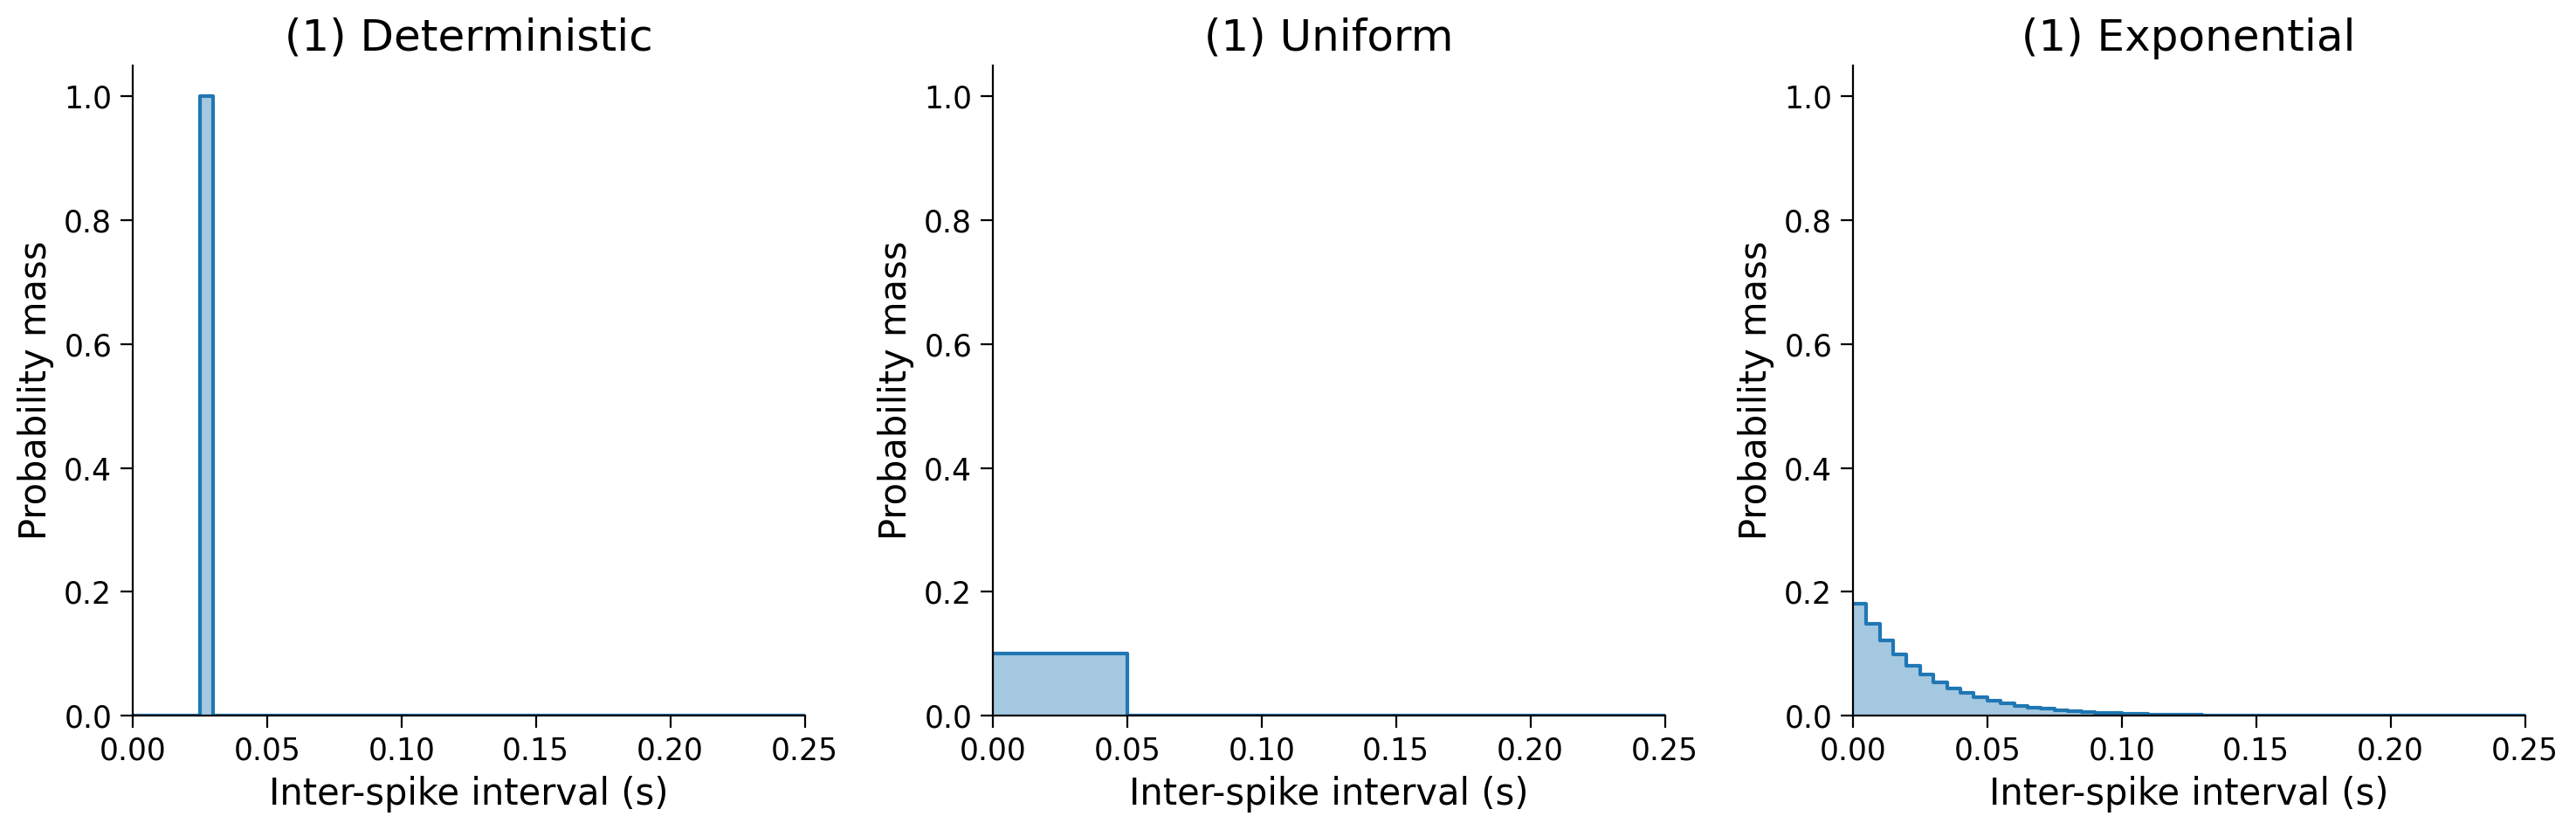

In [ ]:
# @markdown Run this cell to plot the three PMFs
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

dists =  [# (subplot title, pmf, ylim)
          ("(1) Deterministic", pmf_single, (0, 1.05)),
          ("(1) Uniform", pmf_uniform, (0, 1.05)),
          ("(1) Exponential", pmf_exp, (0, 1.05))]

for ax, (label, pmf_, ylim) in zip(axes, dists):
  pmf_ = np.insert(pmf_, 0, pmf_[0])
  ax.plot(bins, pmf_, drawstyle="steps")
  ax.fill_between(bins, pmf_, step="pre", alpha=0.4)
  ax.set_title(label)
  ax.set_xlabel("Inter-spike interval (s)")
  ax.set_ylabel("Probability mass")
  ax.set_xlim(isi_range)
  ax.set_ylim(ylim)
plt.show()

In [ ]:
print(
  f"Deterministic: {entropy(pmf_single):.2f} bits",
  f"Uniform: {entropy(pmf_uniform):.2f} bits",
  f"Exponential: {entropy(pmf_exp):.2f} bits",
  sep="\n",
)

Deterministic: 0.00 bits
Uniform: 3.32 bits
Exponential: 3.77 bits


---
# Calculating entropy of ISI distributions from data

## Computing probabilities from histogram

In the previous example we created the PMFs by hand to illustrate idealized scenarios. How would we compute them from data recorded from actual neurons?

One way is to convert the ISI histograms we've previously computed into discrete probability distributions using the following equation:

\begin{equation}
p_i = \frac{n_i}{\sum\nolimits_{i}n_i}
\end{equation}

where $p_i$ is the probability of an ISI falling within a particular interval $i$ and $n_i$ is the count of how many ISIs were observed in that interval.

### Probability Mass Function

Your second exercise is to implement a method that will produce a probability mass function from an array of ISI bin counts.

To verify your solution, we will compute the probability distribution of ISIs from real neural data taken from the Steinmetz dataset.

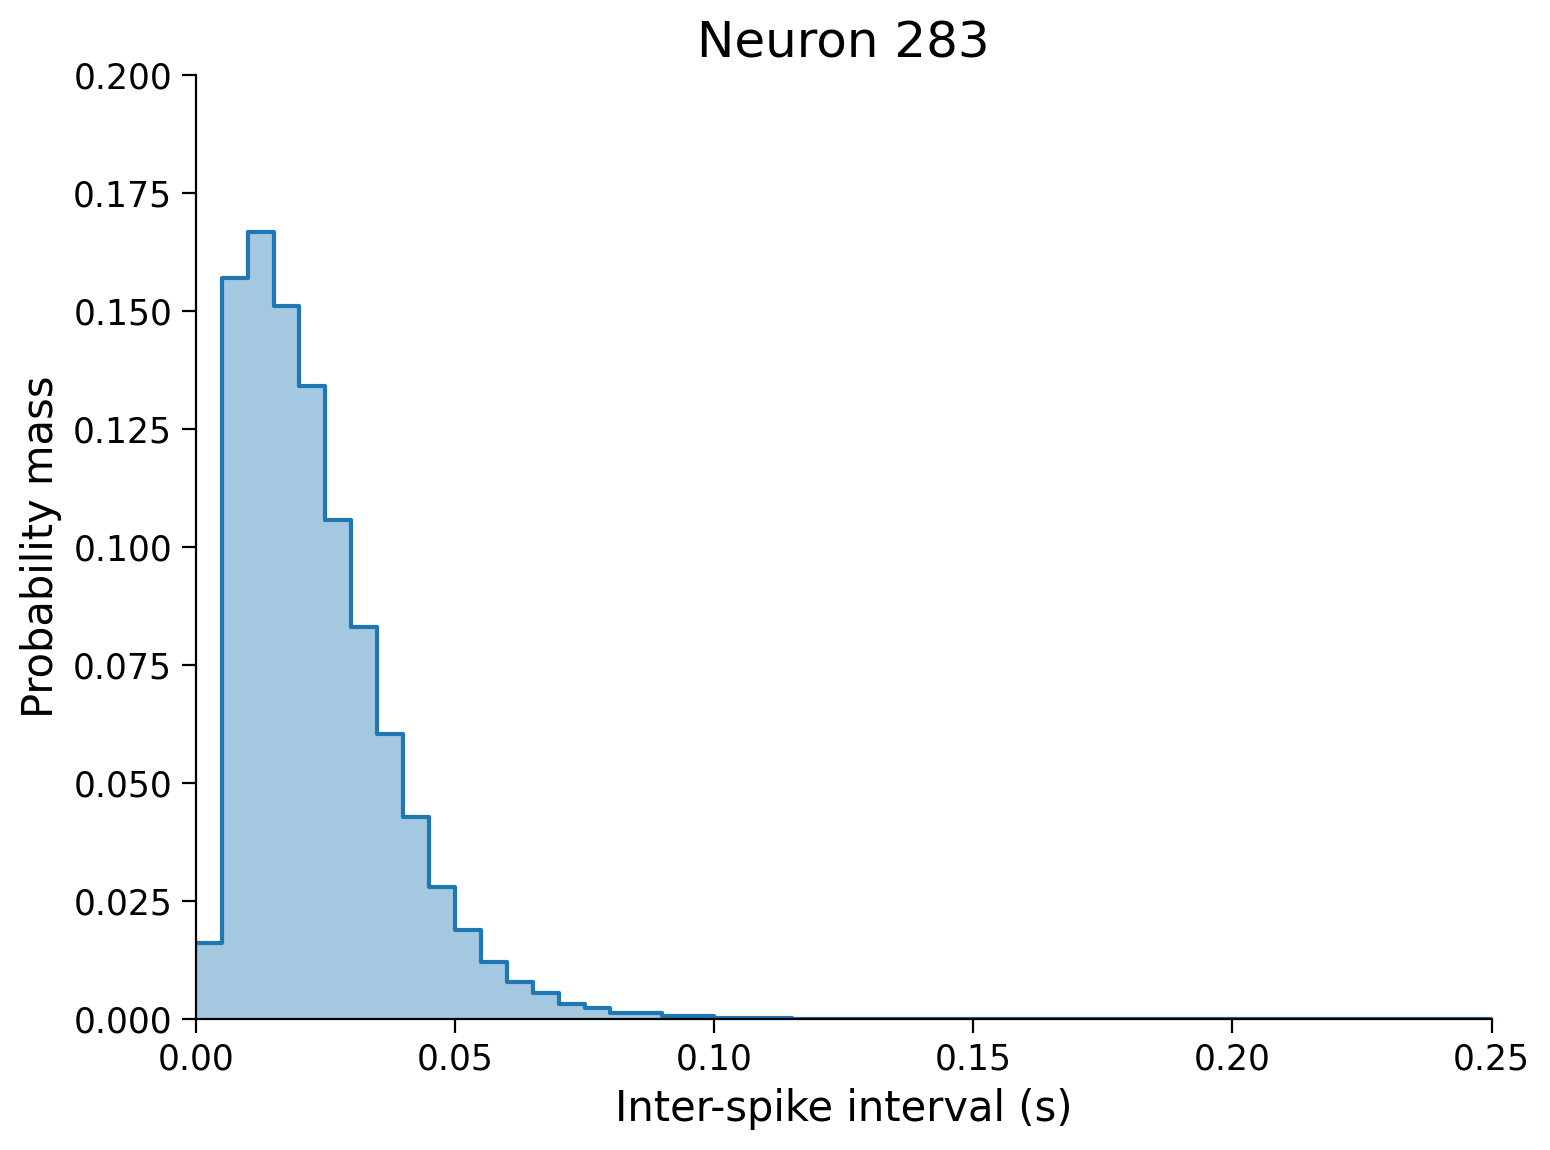

In [ ]:
def pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""

  pmf = counts / np.sum(counts)

  return pmf


# Get neuron index
neuron_idx = 283

# Get counts of ISIs from Steinmetz data
isi = np.diff(steinmetz_spikes[neuron_idx])
bins = np.linspace(*isi_range, n_bins + 1)
counts, _ = np.histogram(isi, bins)

# Compute pmf
pmf = pmf_from_counts(counts)

# Visualize
plot_pmf(pmf, isi_range)

## Calculating entropy from pmf

Now that we have the probability distribution for the actual neuron spiking activity, we can calculate its entropy.

In [ ]:
print(f"Entropy for Neuron {neuron_idx}: {entropy(pmf):.2f} bits")

Entropy for Neuron 283: 3.36 bits


### Interactive Demo: Entropy of neurons

We can combine the above distribution plot and entropy calculation with an interactive widget to explore how the different neurons in the dataset vary in spiking activity and relative information. Note that the mean firing rate across neurons is not fixed, so some neurons with a uniform ISI distribution may have higher entropy than neurons with a more exponential distribution.




In [ ]:
# @markdown **Run the cell** to enable the sliders.

def _pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  pmf = counts / np.sum(counts)
  return pmf


def _entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits."""
  # remove non-zero entries to avoid an error from log2(0)
  pmf = pmf[pmf > 0]
  h = -np.sum(pmf * np.log2(pmf))
  # absolute value applied to avoid getting a -0 result
  return np.abs(h)


@widgets.interact(neuron=widgets.IntSlider(0, min=0, max=(len(steinmetz_spikes)-1)))
def steinmetz_pmf(neuron):
  """ Given a neuron from the Steinmetz data, compute its PMF and entropy """
  isi = np.diff(steinmetz_spikes[neuron])
  bins = np.linspace(*isi_range, n_bins + 1)
  counts, _ = np.histogram(isi, bins)
  pmf = _pmf_from_counts(counts)

  plot_pmf(pmf, isi_range)
  plt.title(f"Neuron {neuron}: H = {_entropy(pmf):.2f} bits")
  plt.show()

interactive(children=(IntSlider(value=0, description='neuron', max=733), Output()), _dom_classes=('widget-inte…

---
# Summary

 - We used "what" models to discover that the ISI distribution of real neurons is closest to an exponential distribution
 - We used "how" models to discover that balanced excitatory and inhibitory inputs, coupled with a leaky membrane, can give rise to neuronal spiking with exhibiting such an exponential ISI distribution
 - We used "why" models to discover that exponential ISI distributions contain the most information when the mean spiking is constrained



---
# Notation

\begin{align}
H(X) &\quad \text{entropy of random variable X}\\
b &\quad \text{base, e.g. b=2 or b=e}\\
x &\quad \text{event x}\\
p(x) &\quad \text{probability of observing event x}\\
\text{ISI} &\quad \text{interspike interval}\\
n_i &\quad \text{count of observed ISIs in interval i}\\
p_i  &\quad \text{probability of of an ISI falling within a particular interval i}
\end{align}

---
# Bonus

## The foundations for Entropy

In his foundational [1948 paper](https://en.wikipedia.org/wiki/A_Mathematical_Theory_of_Communication) on information theory, Claude Shannon began with three criteria for a function $H$ defining the entropy of a discrete distribution of probability masses $p_i\in p(X)$ over the points $x_i\in X$:
1. $H$ should be continuous in the $p_i$.
  - That is, $H$ should change smoothly in response to smooth changes to the mass $p_i$ on each point $x_i$.
2. If all the points have equal shares of the probability mass, $p_i=1/N$, $H$ should be a non-decreasing function of $N$.
  - That is, if $X_N$ is the support with $N$ discrete points and $p(x\in X_N)$ assigns constant mass to each point, then $H(X_1) < H(X_2) < H(X_3) < \dots$
3. $H$ should be preserved by (invariant to) the equivalent (de)composition of distributions.
  - For example (from Shannon's paper) if we have a discrete distribution over three points with masses $(\frac{1}{2},\frac{1}{3},\frac{1}{6})$, then their entropy can be represented in terms of a direct choice between the three and calculated $H(\frac{1}{2},\frac{1}{3},\frac{1}{6})$. However, it could also be represented in terms of a series of two choices:
    1. either we sample the point with mass $1/2$ or not (_not_ is the other $1/2$, whose subdivisions are not given in the first choice),
    2. if (with probability $1/2$) we _don't_ sample the first point, we sample one of the two remaining points, masses $1/3$ and $1/6$.
    
    Thus in this case we require that $H(\frac{1}{2},\frac{1}{3},\frac{1}{6})=H(\frac{1}{2},\frac{1}{2}) + \frac{1}{2}H(\frac{1}{3}, \frac{1}{6})$

There is a unique function (up to a linear scaling factor) which satisfies these 3 requirements:

\begin{equation}
H_b(X) = -\sum_{x\in X} p(x) \log_b p(x)
\end{equation}

Where the base of the logarithm $b>1$ controls the units of entropy. The two most common cases are $b=2$ for units of _bits_, and $b=e$ for _nats_.

We can view this function as the expectation of the self-information over a distribution:

\begin{align}
H_b(X) &= \mathbb{E}_{x\in X} \left[I_b(x)\right]\\
I_b(x) &= -\log_b p(x)
\end{align}

Self-information is just the negative logarithm of probability, and is a measure of how surprising an event sampled from the distribution would be. Events with $p(x)=1$ are certain to occur, and their self-information is zero (as is the entropy of the distribution they compose) meaning they are totally unsurprising. The smaller the probability of an event, the higher its self-information, and the more surprising the event would be to observe.
